In [1]:
# Load modules for data management
import pandas as pd
import numpy as np
import re
import patsy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter

# Import necessary modules for classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set figure DPI for publication quality for matplotlib.pyplot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# ...and seaborn
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sns.set_style('white')


In [11]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("SEEROutput.csv",low_memory=False)
# Look at data header
# display(salivary_df.head())
display(salivary_df.info())
display(salivary_df.columns)

small_df = salivary_df.sample(1000)
small_df.to_csv('output.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28030 entries, 0 to 28029
Data columns (total 64 columns):
 #   Column                                                     Non-Null Count  Dtype 
---  ------                                                     --------------  ----- 
 0   Patient ID                                                 28030 non-null  int64 
 1   Age recode with <1 year olds                               28030 non-null  object
 2   Sex                                                        28030 non-null  object
 3   Year of diagnosis                                          28030 non-null  int64 
 4   PRCDA 2020                                                 28030 non-null  object
 5   Race recode (W, B, AI, API)                                28030 non-null  object
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    28030 non-null  object
 7   Site recode ICD-O-3/WHO 2008                               28030 non-null  object
 8   Behavior code IC

None

Index(['Patient ID', 'Age recode with <1 year olds', 'Sex',
       'Year of diagnosis', 'PRCDA 2020', 'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3',
       'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
       'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
       'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
       'ICD-O-3 Hist/behav, malignant', 'Histology recode - broad groupings',
       'Site recode ICD-O-3/WHO 2008 (for SIRs)',
       'Combined Summary Stage (2004+)', 'Summary stage 2000 (1998-2017)',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'SEER historic stage A (1973-2015)', 'RX Summ--Surg Prim Site (1998+)',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
       'Reason no can

# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we may need to address missing values individually. They may be logged as, for example, 'XX' or '99' or 'Unknown'. As such, we will always view unique values in each column before evaluations and strive to identify anything that may be a missing value.


# Data Cleaning: Categorical Adjustments and  Orders Including Histology and Grade 

array(['White', 'Asian or Pacific Islander', 'Black',
       'American Indian/Alaska Native', 'Unknown'], dtype=object)

In [53]:
# Select relevant columns for demographic analysis
age_colname = 'Age recode with single ages and 90+'
age_bin_colname = 'Age_Binned'
race_colname = 'Race recode (W, B, AI, API)'
sex_colname = 'Sex'
ses_colname = 'Median household income inflation adj to 2022'
site_colname = 'Primary Site - labeled'
marital_colname = 'Marital status at diagnosis'

# Define a function to extract numerical values from median income
def extract_midpoint(income_str):
    # Check if the income string represents an open-ended range (e.g., "$120,000+")
    income_str = income_str.replace(',','')
    if '+' in income_str:
        # Extract the number before the '+' and return it as a float
        return float(re.sub(r'[^\d]', '', income_str))

    # Check if the income string represents a range (e.g., "$40,000 - $44,999")
    elif '-' in income_str:
        # Extract the two numbers and calculate the midpoint
        numbers = re.findall(r'\d+', income_str)
        lower_bound = float(numbers[0])
        upper_bound = float(numbers[1])
        midpoint = (lower_bound + upper_bound) / 2
        return midpoint

    # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
    elif '<' in income_str:
        # Extract the number and treat it as the threshold value
        return float(re.sub(r'[^\d]', '', income_str))

    # If the string does not match any of the patterns, return NaN
    return np.nan

# Apply the function to the income column
salivary_df['Income_numeric'] = salivary_df['Median household income inflation adj to 2022'].apply(extract_midpoint)
salivary_df['Income_numeric'] = salivary_df['Income_numeric'].astype('double')
# Step 3: Create a new column with quartile assignments
salivary_df['Income_quartile'] = pd.qcut(salivary_df['Income_numeric'], q=4, labels=["Lowest quartile", "Lower middle quartile", "Upper middle quartile", "Highest quartile"])
# salivary_df['Income_quartile'] = salivary_df['Income_quartile'].cat.reorder_categories(['Highest quartile','Upper middle quartile','Lower middle quartile','Lowest quartile'],ordered=True)

# Perform the quartile cut and directly assign to a new variable to examine the Categorical object
quartile_cut = pd.qcut(salivary_df['Income_numeric'], q=4)

# Access the categories (intervals) from the Categorical object
quartile_bins = quartile_cut.cat.categories

demographic_columns = [age_colname,race_colname,sex_colname, ses_colname]

# Remove 'years'
salivary_df[age_colname] = salivary_df[age_colname].str.replace(' years','') 

# Organize age column as a categorical with numerical order
numerical_years = salivary_df[age_colname].str.extract(r'(\d+)').astype(float)
# print(numerical_years[0].unique())
# Input numerical age data into the dataframe
salivary_df['Numerical_Age'] = numerical_years


# Define 5-year bins from 0 to 90+, using float to allow for infinity in the final bin
bins = np.concatenate([np.arange(0, 95, 5), [np.inf]])  # Include infinity in the last bin

# Create labels for the bins, including '90+' for the last bin
labels = [f'{i}-{i+4}' for i in range(0, 90, 5)] + ['90+']

# Apply pd.cut to create the binned age categories
salivary_df[age_bin_colname] = pd.cut(salivary_df['Numerical_Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Check the unique values of the new binned age column
# print(salivary_df[age_bin_colname].unique())
# Create a mapping for values with leading zeros and handle special cases:
# - Convert '00' and '<1' to '≤1'
# - Remove leading zeros for values like '02', '03', etc.
# - Leave '90' as it is

sorted_ages = salivary_df[age_colname].unique()
age_mapping = {
    age: '≤1' if age == '00' or age == '<1' else (str(int(age)) if age.isdigit() and int(age) < 10 else age)
    for age in sorted_ages
}

# Replace values in the age column using the mapping
salivary_df[age_colname] = salivary_df[age_colname].replace(age_mapping)

# Get the sorted unique ages after the mapping has been applied
# Ensure '≤1' comes first by assigning key paramter = -1
# Otherwise: get rid of "+" at the end of 90
sorted_ages = sorted(
    salivary_df[age_colname].unique(),
    key=lambda x: (-1 if '≤1' in x else float(x.replace('+', '').replace('≤', '').replace('<', ''))) if x != '90+' else 90
)

# Convert the 'age_colname' column to categorical with sorted order
salivary_df[age_colname] = pd.Categorical(salivary_df[age_colname], categories=sorted_ages, ordered=True)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df[sex_colname] = pd.Categorical(
    salivary_df[sex_colname], categories=sex_order, ordered=True
)

# Race order
race_order = ['White','Black','Asian or Pacific Islander','American Indian/Alaskan Native','Unknown']

# Convert race column to reflect new world order
salivary_df[race_colname] = pd.Categorical(
    salivary_df[race_colname], categories=race_order, ordered=True
)

# display(salivary_df[age_colname].unique)


# SES
# Define the order of categories
socioeconomic_order = [
    "<$40,000", "$40,000 - $44,999", "$45,000 - $49,999", "$50,000 - $54,999",
    "$55,000 - $59,999", "$60,000 - $64,999", "$65,000 - $69,999", "$70,000 - $74,999",
    "$75,000 - $79,999", "$80,000 - $84,999", "$85,000 - $89,999", "$90,000 - $94,999",
    "$95,000 - $99,999", "$100,000 - $109,999", "$110,000 - $119,999", "$120,000+"
]

# Change to categorical
salivary_df[ses_colname] = pd.Categorical(
    salivary_df[ses_colname],
    categories=socioeconomic_order,
    ordered=True
)

# Marital mapping
marital_map = {'Divorced':'Divorced/Separated',
               'Separated':'Divorced/Separated',
               'Married (including common law)':'Married',
               'Single (never married)':'Single',
               'Unmarried or Domestic Partner':'Domestic Partner'}

salivary_df[marital_colname] = salivary_df[marital_colname].replace(marital_map).astype('category')
marital_order = ['Married', 'Single', 'Divorced/Separated', 'Widowed', 'Domestic Partner','Unknown']
salivary_df[marital_colname] = pd.Categorical(salivary_df[marital_colname], categories=marital_order, ordered=True)

print(salivary_df[marital_colname].unique())
# Categorize histological types - based on Baddour, JAMA Otolaryngol Head Neck Surg, 2015
mec_code = ['8430']
acc_code = ['8200']
adenocarcinoma_code = ['8140','8147','8290','8310','8410','8440','8480','8525','8550']
mixed_code = ['8980','8981']
rare_code = ['8012','8041','8082','8562','8982']

all_codes = mec_code + acc_code + adenocarcinoma_code + mixed_code + rare_code

# Function to map each code to a category
def categorize_histology(code):
    if code in mec_code:
        return 'Mucoepidermoid Carcinoma'
    elif code in acc_code:
        return 'Adenoid Cystic Carcinoma'
    elif code in adenocarcinoma_code:
        return 'Adenocarcinoma'
    elif code in mixed_code:
        return 'Mixed Subtypes'
    elif code in rare_code:
        return 'Other Rare Types'
    else:
        return 'Other'

# Extract 4 digit ICD-O-3 Code:
salivary_df['ICD-O-3 Code'] = salivary_df['ICD-O-3 Hist/behav'].str.extract(r'(\d{4})')

# Filter the DataFrame to include only rows where the 'ICD-O-3 Code' is in your list of codes
filtered_df = salivary_df[salivary_df['ICD-O-3 Code'].isin(all_codes)]

# Use assign to apply the histology categorization
filtered_df = filtered_df.assign(Histology=filtered_df['ICD-O-3 Code'].apply(categorize_histology))

# View the filtered DataFrame
# display(filtered_df[['ICD-O-3 Code', 'ICD-O-3 Hist/behav', 'Histology']])
# Define the ordered grade labels
grade_order = ['Grade I', 'Grade II', 'Grade III', 'Grade IV', 'Unknown']

# Grade Mapping
grade_mapping = {'Unknown':'Unknown',
 'Moderately differentiated; Grade II':'Grade II',
 'Well differentiated; Grade I': 'Grade I',
 'Poorly differentiated; Grade III': 'Grade III',
 'Undifferentiated; anaplastic; Grade IV': 'Grade IV'}

# apply mapping + convert to categorical
filtered_df['Grade Label'] = filtered_df['Grade Recode (thru 2017)'].map(grade_mapping)
filtered_df['Grade Label'] = pd.Categorical(filtered_df['Grade Label'], categories=grade_order, ordered=True)

# Grade Level Mapping
grade_level_mapping = {'Unknown':'Unknown',
                 'Moderately differentiated; Grade II':'Intermediate',
                 'Well differentiated; Grade I': 'Low',
                 'Poorly differentiated; Grade III': 'High',
                 'Undifferentiated; anaplastic; Grade IV': 'High'}

# apply mapping + convert to categorical
filtered_df['Grade Level'] = filtered_df['Grade Recode (thru 2017)'].map(grade_level_mapping)
filtered_df['Grade Level'] = pd.Categorical(filtered_df['Grade Level'], categories=['Low','Intermediate','High','Unknown'], ordered=True)
display(filtered_df)



['Married', 'Divorced/Separated', 'Widowed', 'Single', 'Unknown', 'Domestic Partner']
Categories (6, object): ['Married' < 'Single' < 'Divorced/Separated' < 'Widowed' < 'Domestic Partner' < 'Unknown']


Patient ID Age recode with <1 year olds     Sex  Year of diagnosis  \
0            1154                  75-79 years    Male               2016   
3            4395                  65-69 years  Female               2019   
5            5648                    85+ years    Male               2004   
6            6248                  25-29 years  Female               2004   
7            9663                  45-49 years    Male               2019   
...           ...                          ...     ...                ...   
28014    63331700                  70-74 years  Female               2021   
28015    63332021                  65-69 years    Male               2021   
28020    63332424                  55-59 years  Female               2021   
28024    63339600                  45-49 years    Male               2021   
28025    63340588                  60-64 years  Female               2020   

      PRCDA 2020 Race recode (W, B, AI, API)  \
0      Not PRCDA                       White   
3      Not PRCDA                       White   
5      Not PRCDA                       White   
6      Not PRCDA                       White   
7      Not PRCDA                       White   
...          ...                         ...   
28014  Not PRCDA                       White   
28015  Not PRCDA                       Black   
28020  Not PRCDA                       White   
28024  Not PRCDA                       White   
28025  Not PRCDA                       White   

      Origin recode NHIA (Hispanic, Non-Hisp) Site recode ICD-O-3/WHO 2008  \
0                 Non-Spanish-Hispanic-Latino               Salivary Gland   
3                 Non-Spanish-Hispanic-Latino               Salivary Gland   
5                 Non-Spanish-Hispanic-Latino               Salivary Gland   
6                 Non-Spanish-Hispanic-Latino               Salivary Gland   
7                     Spanish-Hispanic-Latino               Salivary Gland   
...                                       ...                          ...   
28014                 Spanish-Hispanic-Latino               Salivary Gland   
28015             Non-Spanish-Hispanic-Latino               Salivary Gland   
28020             Non-Spanish-Hispanic-Latino               Salivary Gland   
28024             Non-Spanish-Hispanic-Latino               Salivary Gland   
28025             Non-Spanish-Hispanic-Latino               Salivary Gland   

      Behavior code ICD-O-3     Primary Site - labeled  ...  \
0                 Malignant        C07.9-Parotid gland  ...   
3                 Malignant        C07.9-Parotid gland  ...   
5                 Malignant        C07.9-Parotid gland  ...   
6                 Malignant        C07.9-Parotid gland  ...   
7                 Malignant        C07.9-Parotid gland  ...   
...                     ...                        ...  ...   
28014             Malignant        C07.9-Parotid gland  ...   
28015             Malignant        C07.9-Parotid gland  ...   
28020             Malignant        C07.9-Parotid gland  ...   
28024             Malignant  C08.0-Submandibular gland  ...   
28025             Malignant        C07.9-Parotid gland  ...   

       Median household income inflation adj to 2022  \
0                                          $120,000+   
3                                          $120,000+   
5                                $110,000 - $119,999   
6                                  $95,000 - $99,999   
7                                $110,000 - $119,999   
...                                              ...   
28014                              $75,000 - $79,999   
28015                              $75,000 - $79,999   
28020                                      $120,000+   
28024                              $50,000 - $54,999   
28025                              $65,000 - $69,999   

                              Rural-Urban Continuum Code Numerical_Age  \
0        Counties in metropolitan areas ge 1 million pop        

# Race v. Age; Sex v. Age; Income Distribution

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/2767893943.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/2767893943.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/2767893943.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/2767893943.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xtickla

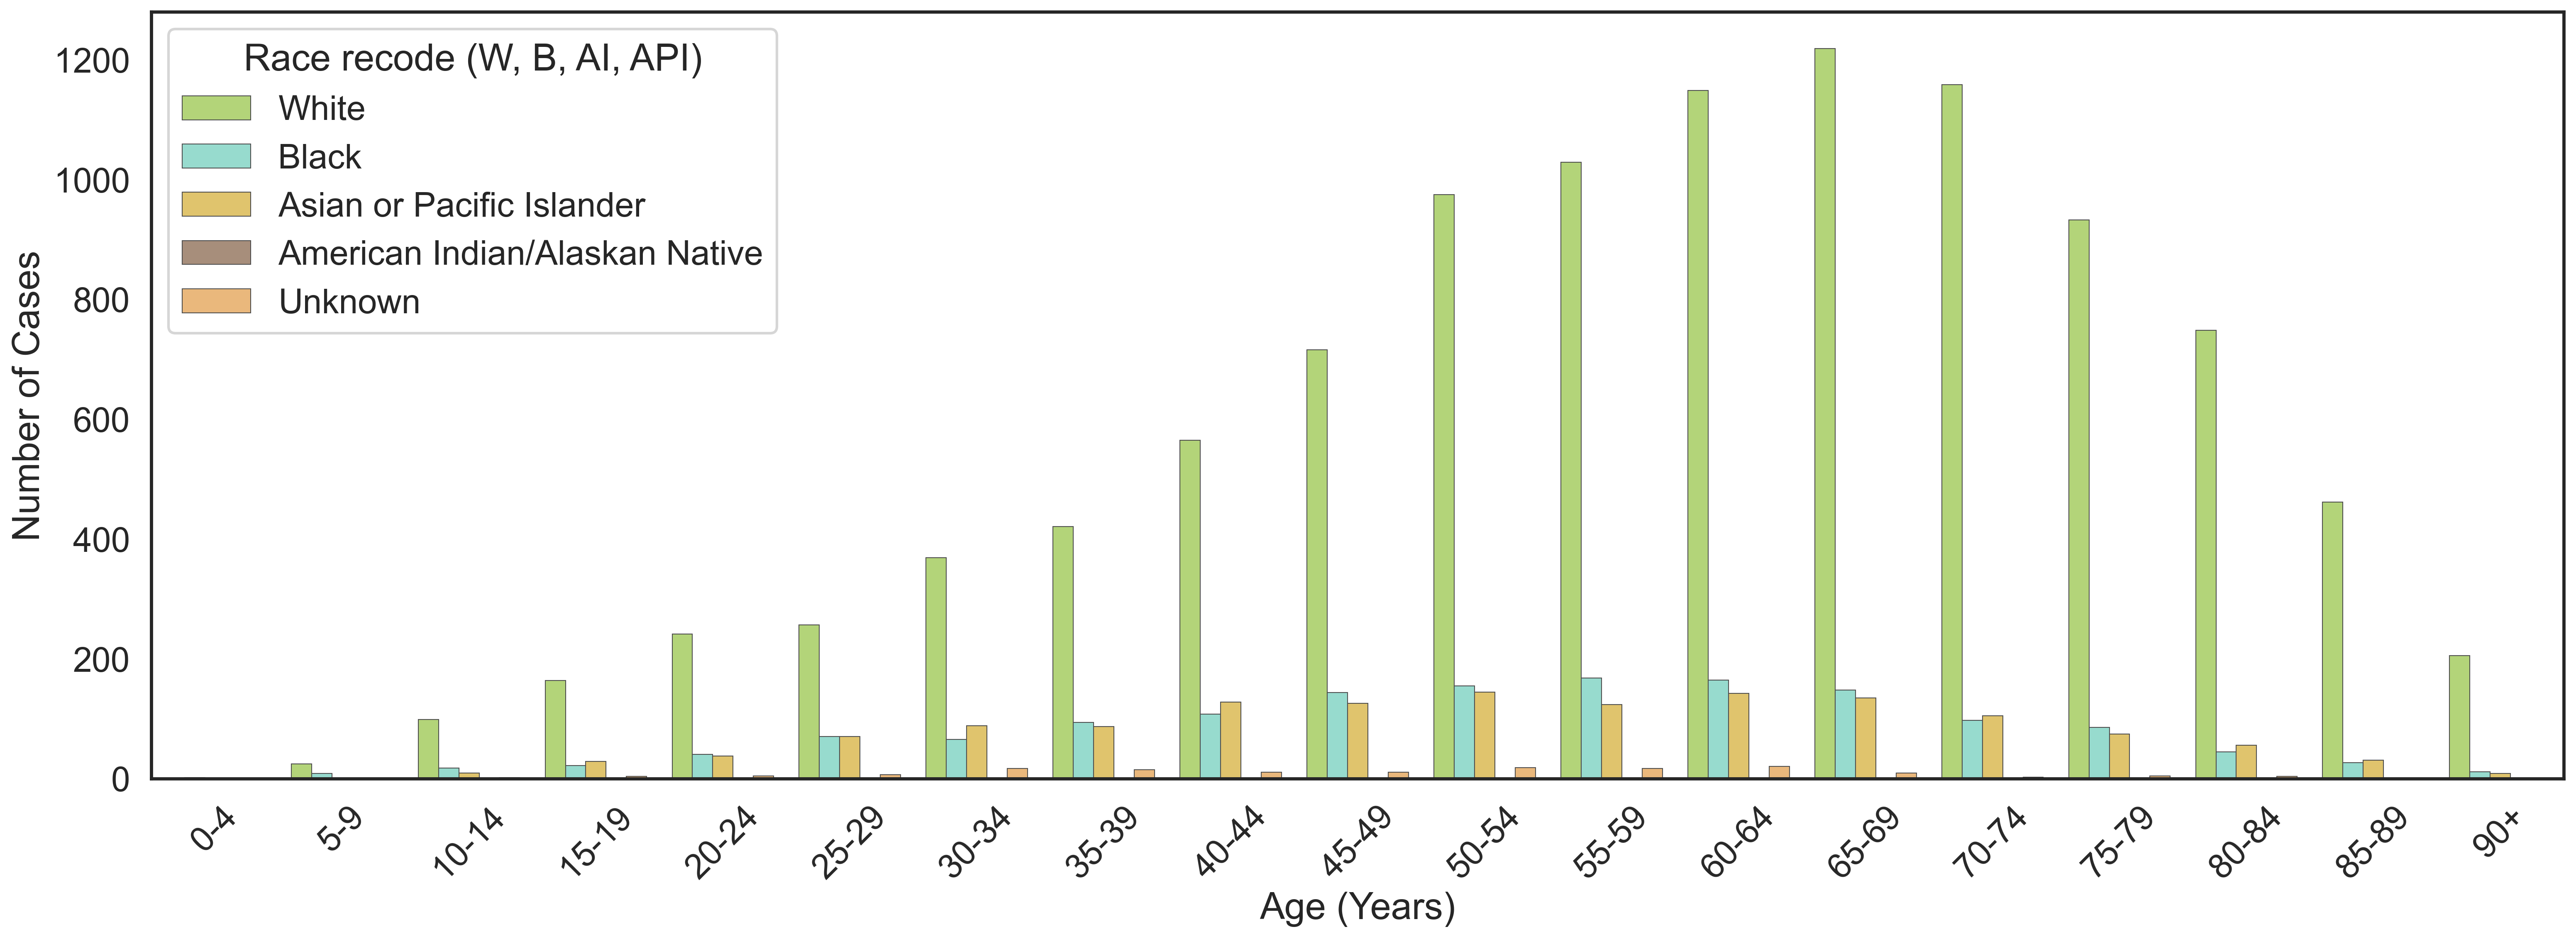

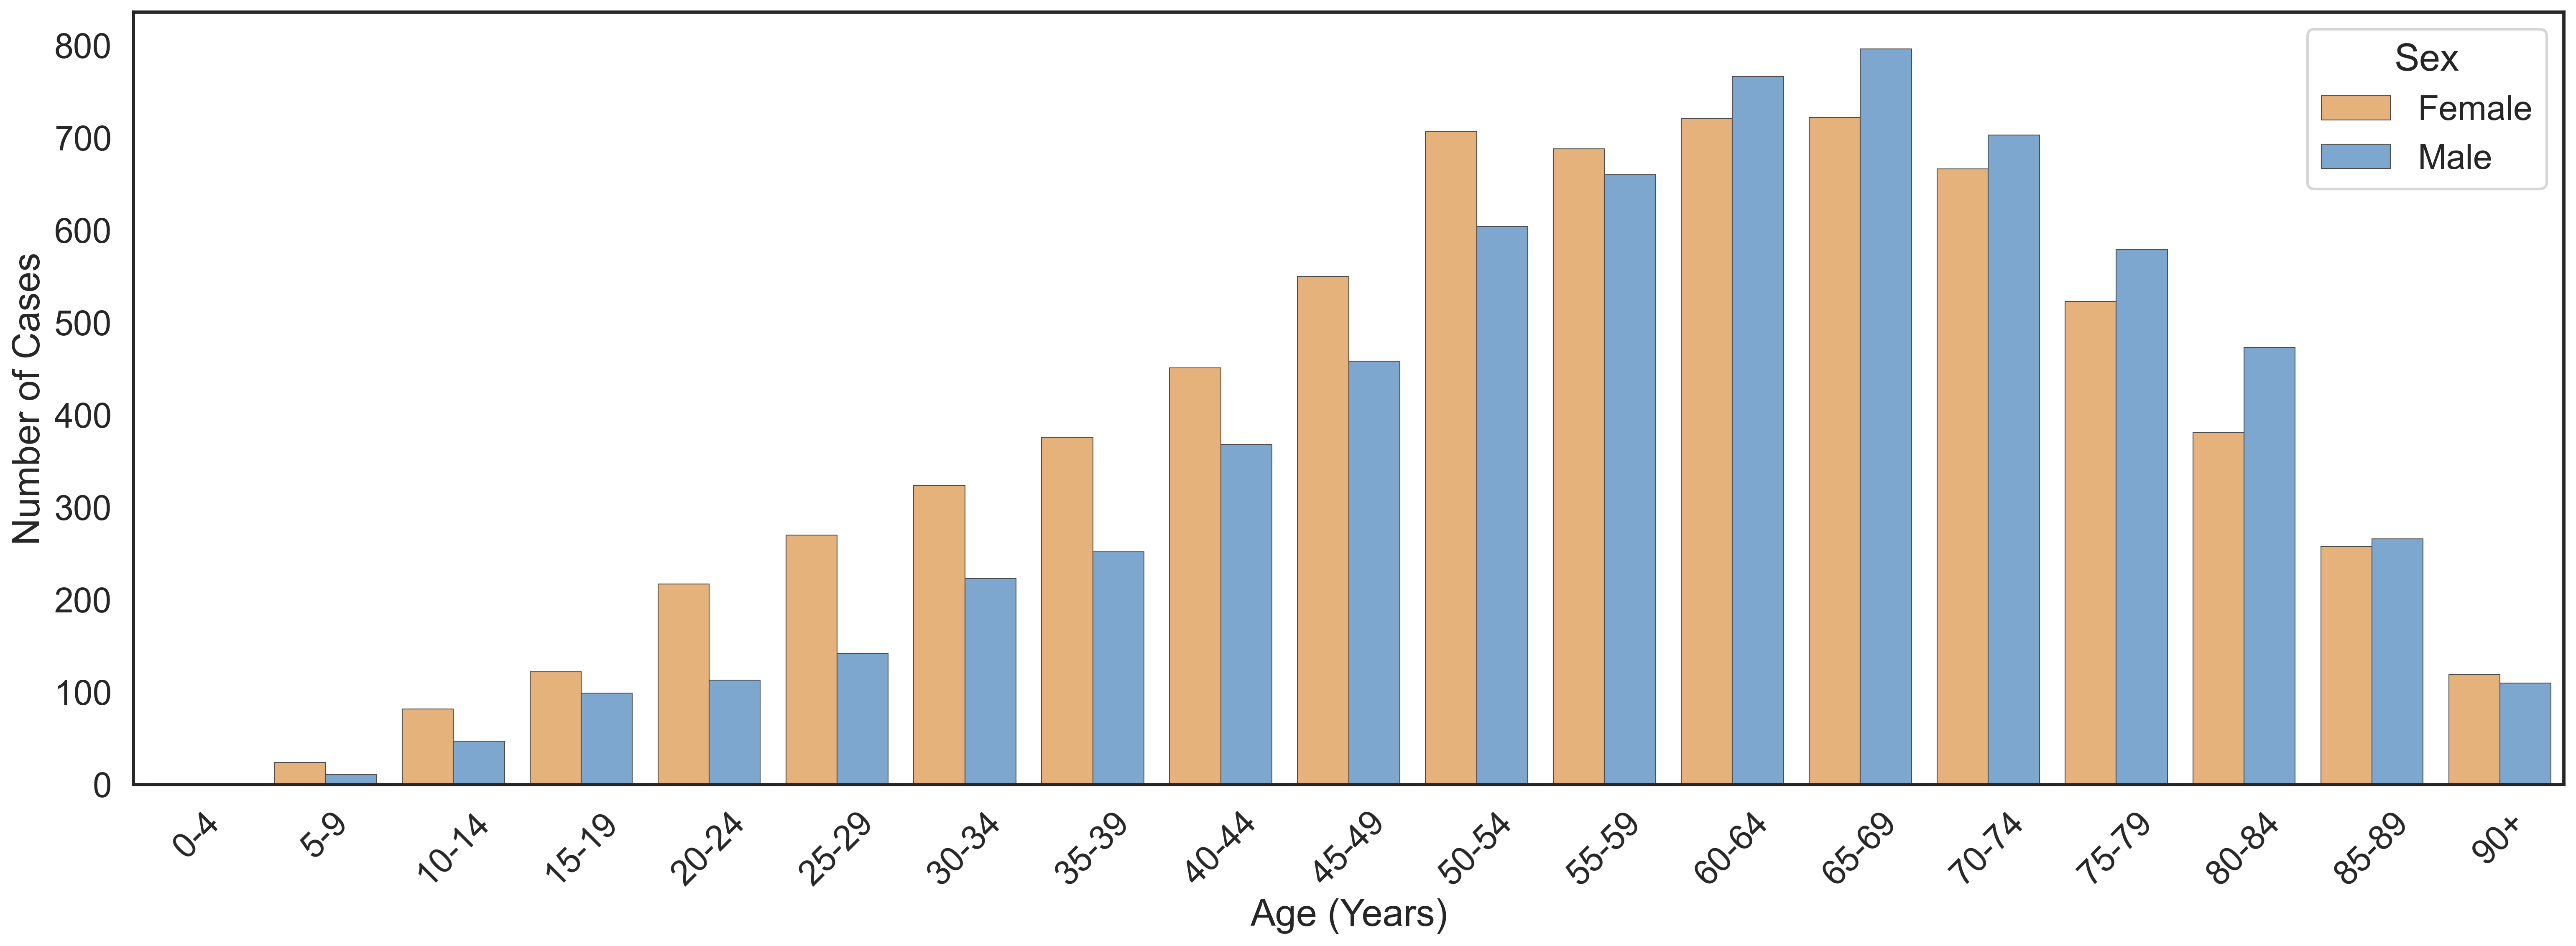

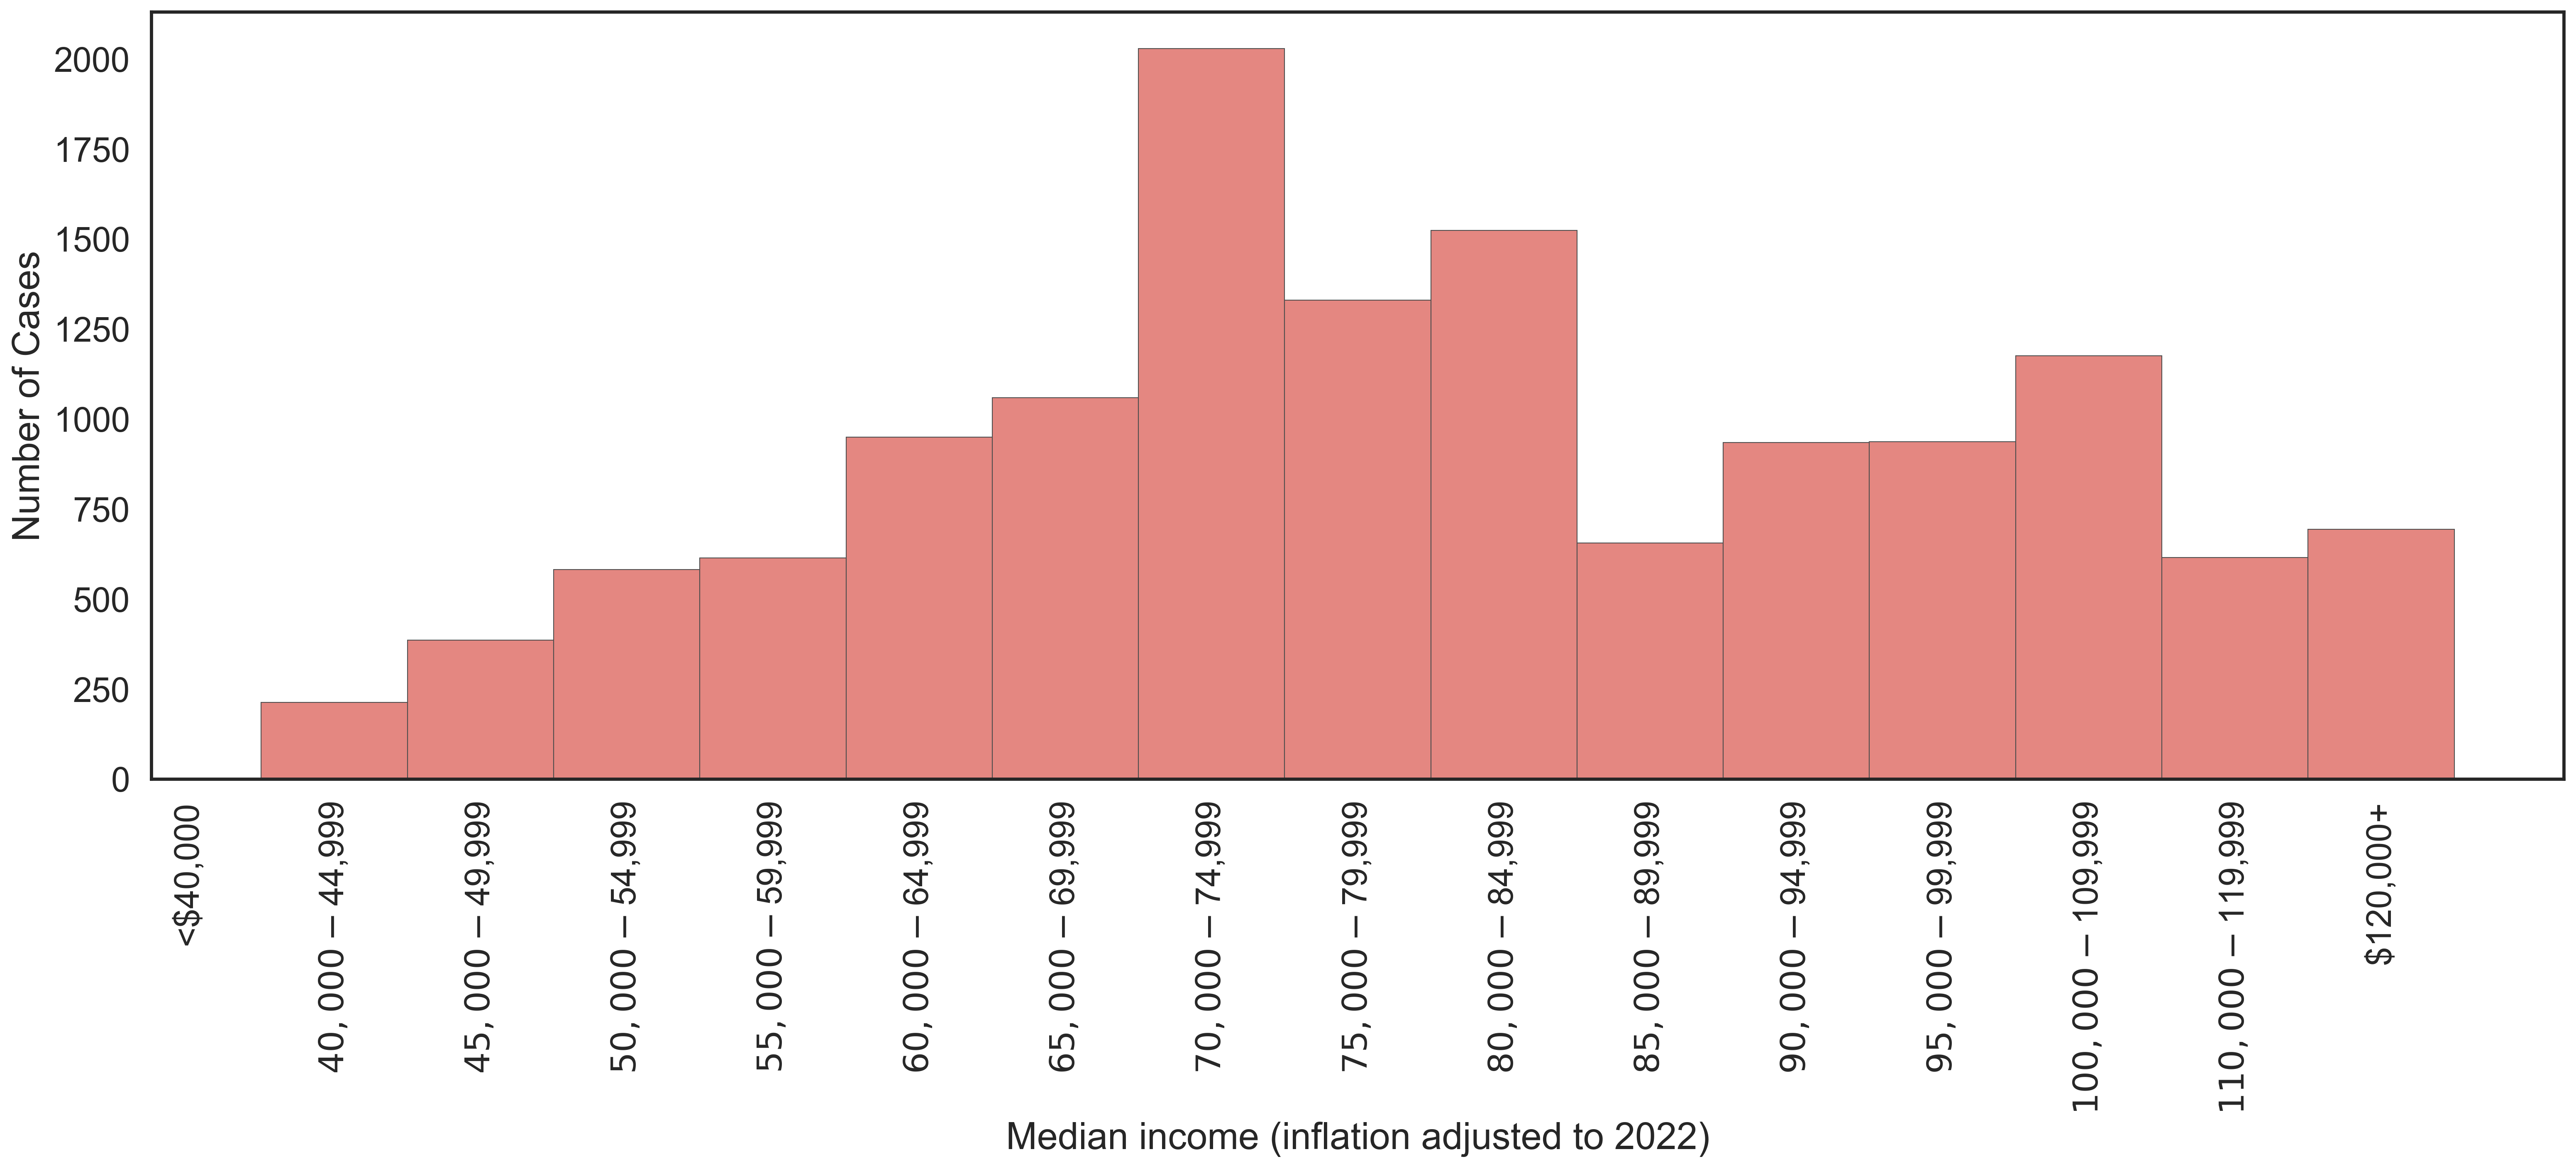

In [83]:

sns.set_style('white')
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')

# Pre-set color palettes
race_colorpalette = ['#b7e36a', '#8ce6d5', '#f3ce5a','#ae8d74','#fcb96a']
sex_colorpalette = ['#f6b26b','#6fa8dc']
ses_colorpalette = sns.color_palette(palette='gist_heat_r', n_colors=len(filtered_df[ses_colname].unique()))
marital_colorpalette = sns.color_palette(palette='inferno_r',n_colors=len(filtered_df[marital_colname].unique()))
# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=race_colname,
    palette=race_colorpalette,
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')

# Save the Race vs. Age plot
plt.savefig('race_vs_age_plot.png', dpi=300, bbox_inches='tight')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=sex_colname,
    palette=sex_colorpalette,
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

# Save the Sex vs. Age plot
plt.savefig('sex_vs_age_plot.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=filtered_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')

# Save the SES histogram
plt.savefig('ses_countplot.png', dpi=300, bbox_inches='tight')


# Socioeconomic Status Heatmap

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/957839321.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)


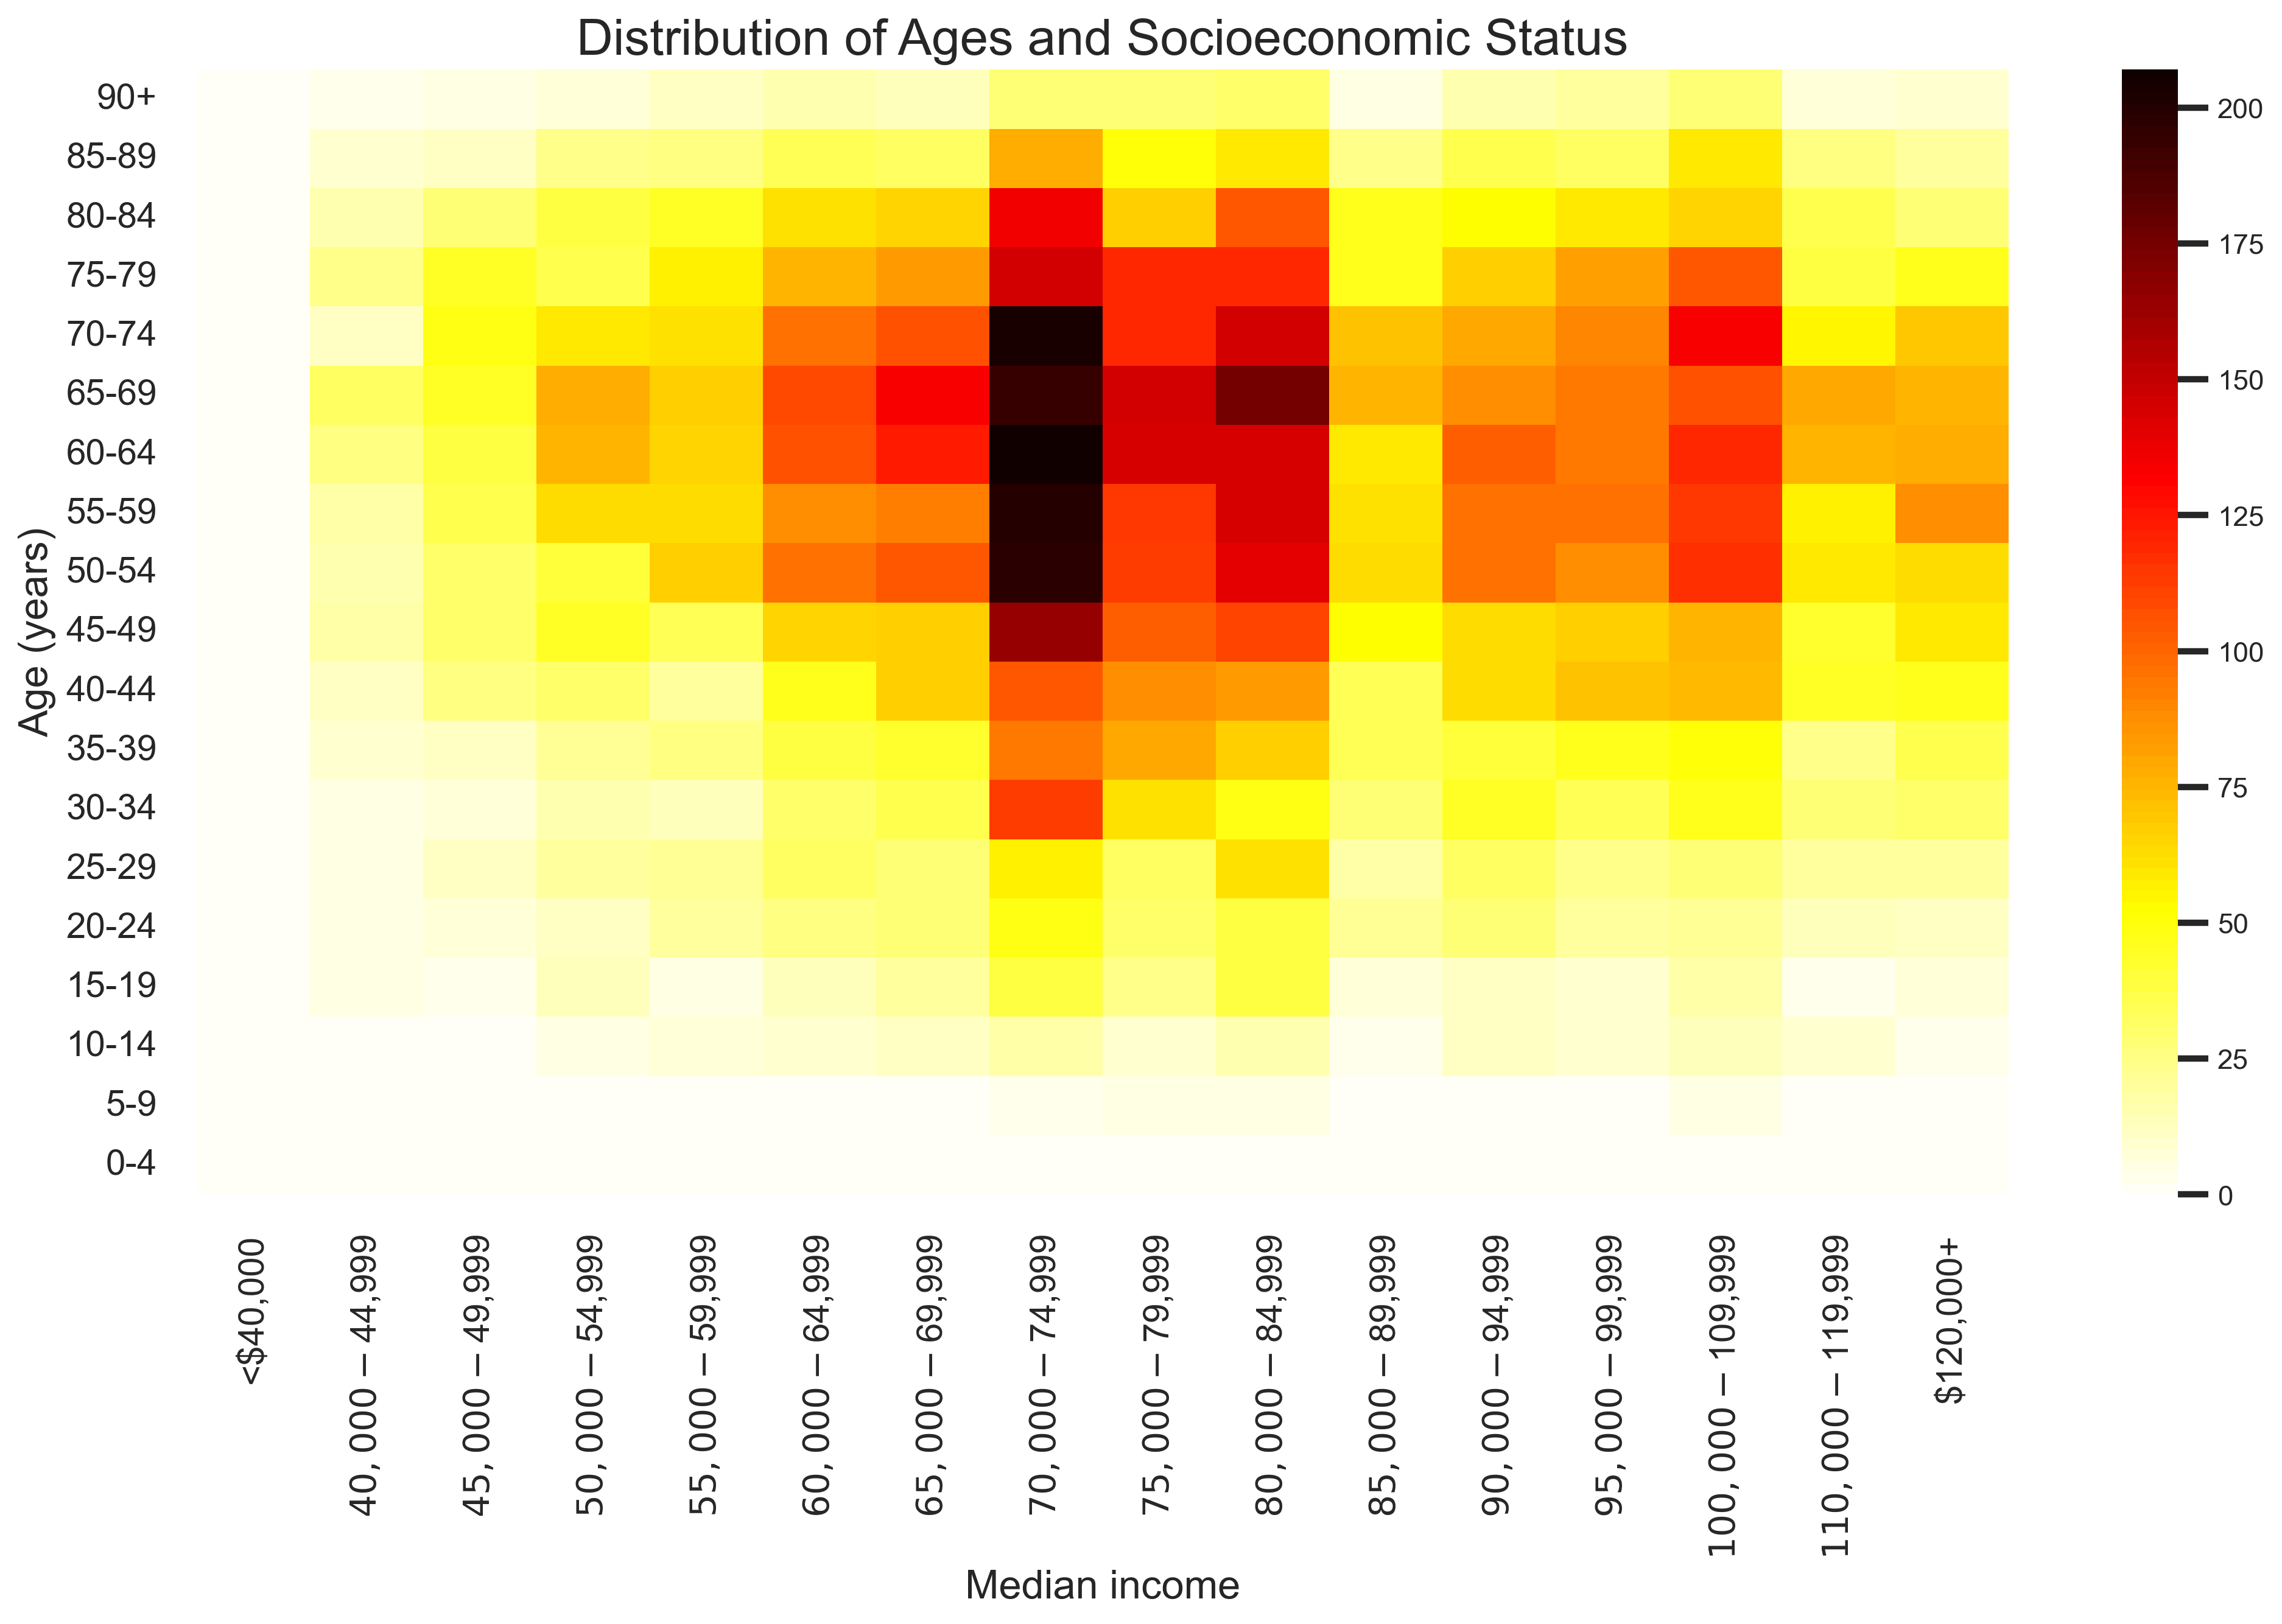

In [55]:
# Heatmap of age and socioeconomic
sns.set_context('poster',font_scale=.5)
# Create a pivot table that calculates the count of occurrences for each age and SES combination
# 
heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)

# Generate the RdYlGn palette with a specific number of colors
palette = sns.color_palette("hot_r",n_colors=100)
# Remove the darkest green, which is typically the last color in the RdYlGn palette
# You can adjust the indices depending on which colors you want to remove
# modified_palette = palette[:-1]  # This removes the last color

# Convert the modified list of colors to a colormap
cmap = sns.color_palette(palette, as_cmap=True)

# Set the figure size before creating the heatmap
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Create the heatmap
ses_heat = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt='d')
ses_heat.invert_yaxis()
title_fs = 20
plt.title('Distribution of Ages and Socioeconomic Status', fontsize=title_fs)
plt.xlabel('Median income', fontsize=title_fs*0.8)
plt.ylabel('Age (years)', fontsize=title_fs*0.8)
plt.xticks(fontsize=title_fs*0.7)
plt.yticks(fontsize=title_fs*0.7)

# Save the SES Heatmap
plt.savefig('ses_heatmap.png', dpi=300, bbox_inches='tight')


# Determine Histological Characterization + Order

In [56]:
# Histology order - Manually Defined and dependent on each dataset
histology_order = ['Adenocarcinoma','Adenoid Cystic Carcinoma','Mucoepidermoid Carcinoma','Other Rare Types','Mixed Subtypes']

# Categorize Histology column based on pre-ordained order
filtered_df['Histology'] = pd.Categorical(filtered_df['Histology'],categories=histology_order, ordered=True)

# For plotting FacetGrid determine the top N types
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order # top cancers

# Pick top N cancers for plotting
N = 3
topCancerTypes = ordered_labels[0:N]
print(topCancerTypes)
filtered_df_forFacetGrid = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]

filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()

# Color Set Up
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors

fullColorDict = dict(zip(histology_order,colors))
topNColorDict = dict(zip(topCancerTypes,colors[0:N]))

fullColorDict

['Adenocarcinoma', 'Adenoid Cystic Carcinoma', 'Mucoepidermoid Carcinoma']


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/1147726711.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()


{'Adenocarcinoma': '#FFB200',
 'Adenoid Cystic Carcinoma': '#30B7AE',
 'Mucoepidermoid Carcinoma': '#BFEF8E',
 'Other Rare Types': '#ffabab',
 'Mixed Subtypes': '#96f1ff'}

## Distribution by Age & Pie Plot

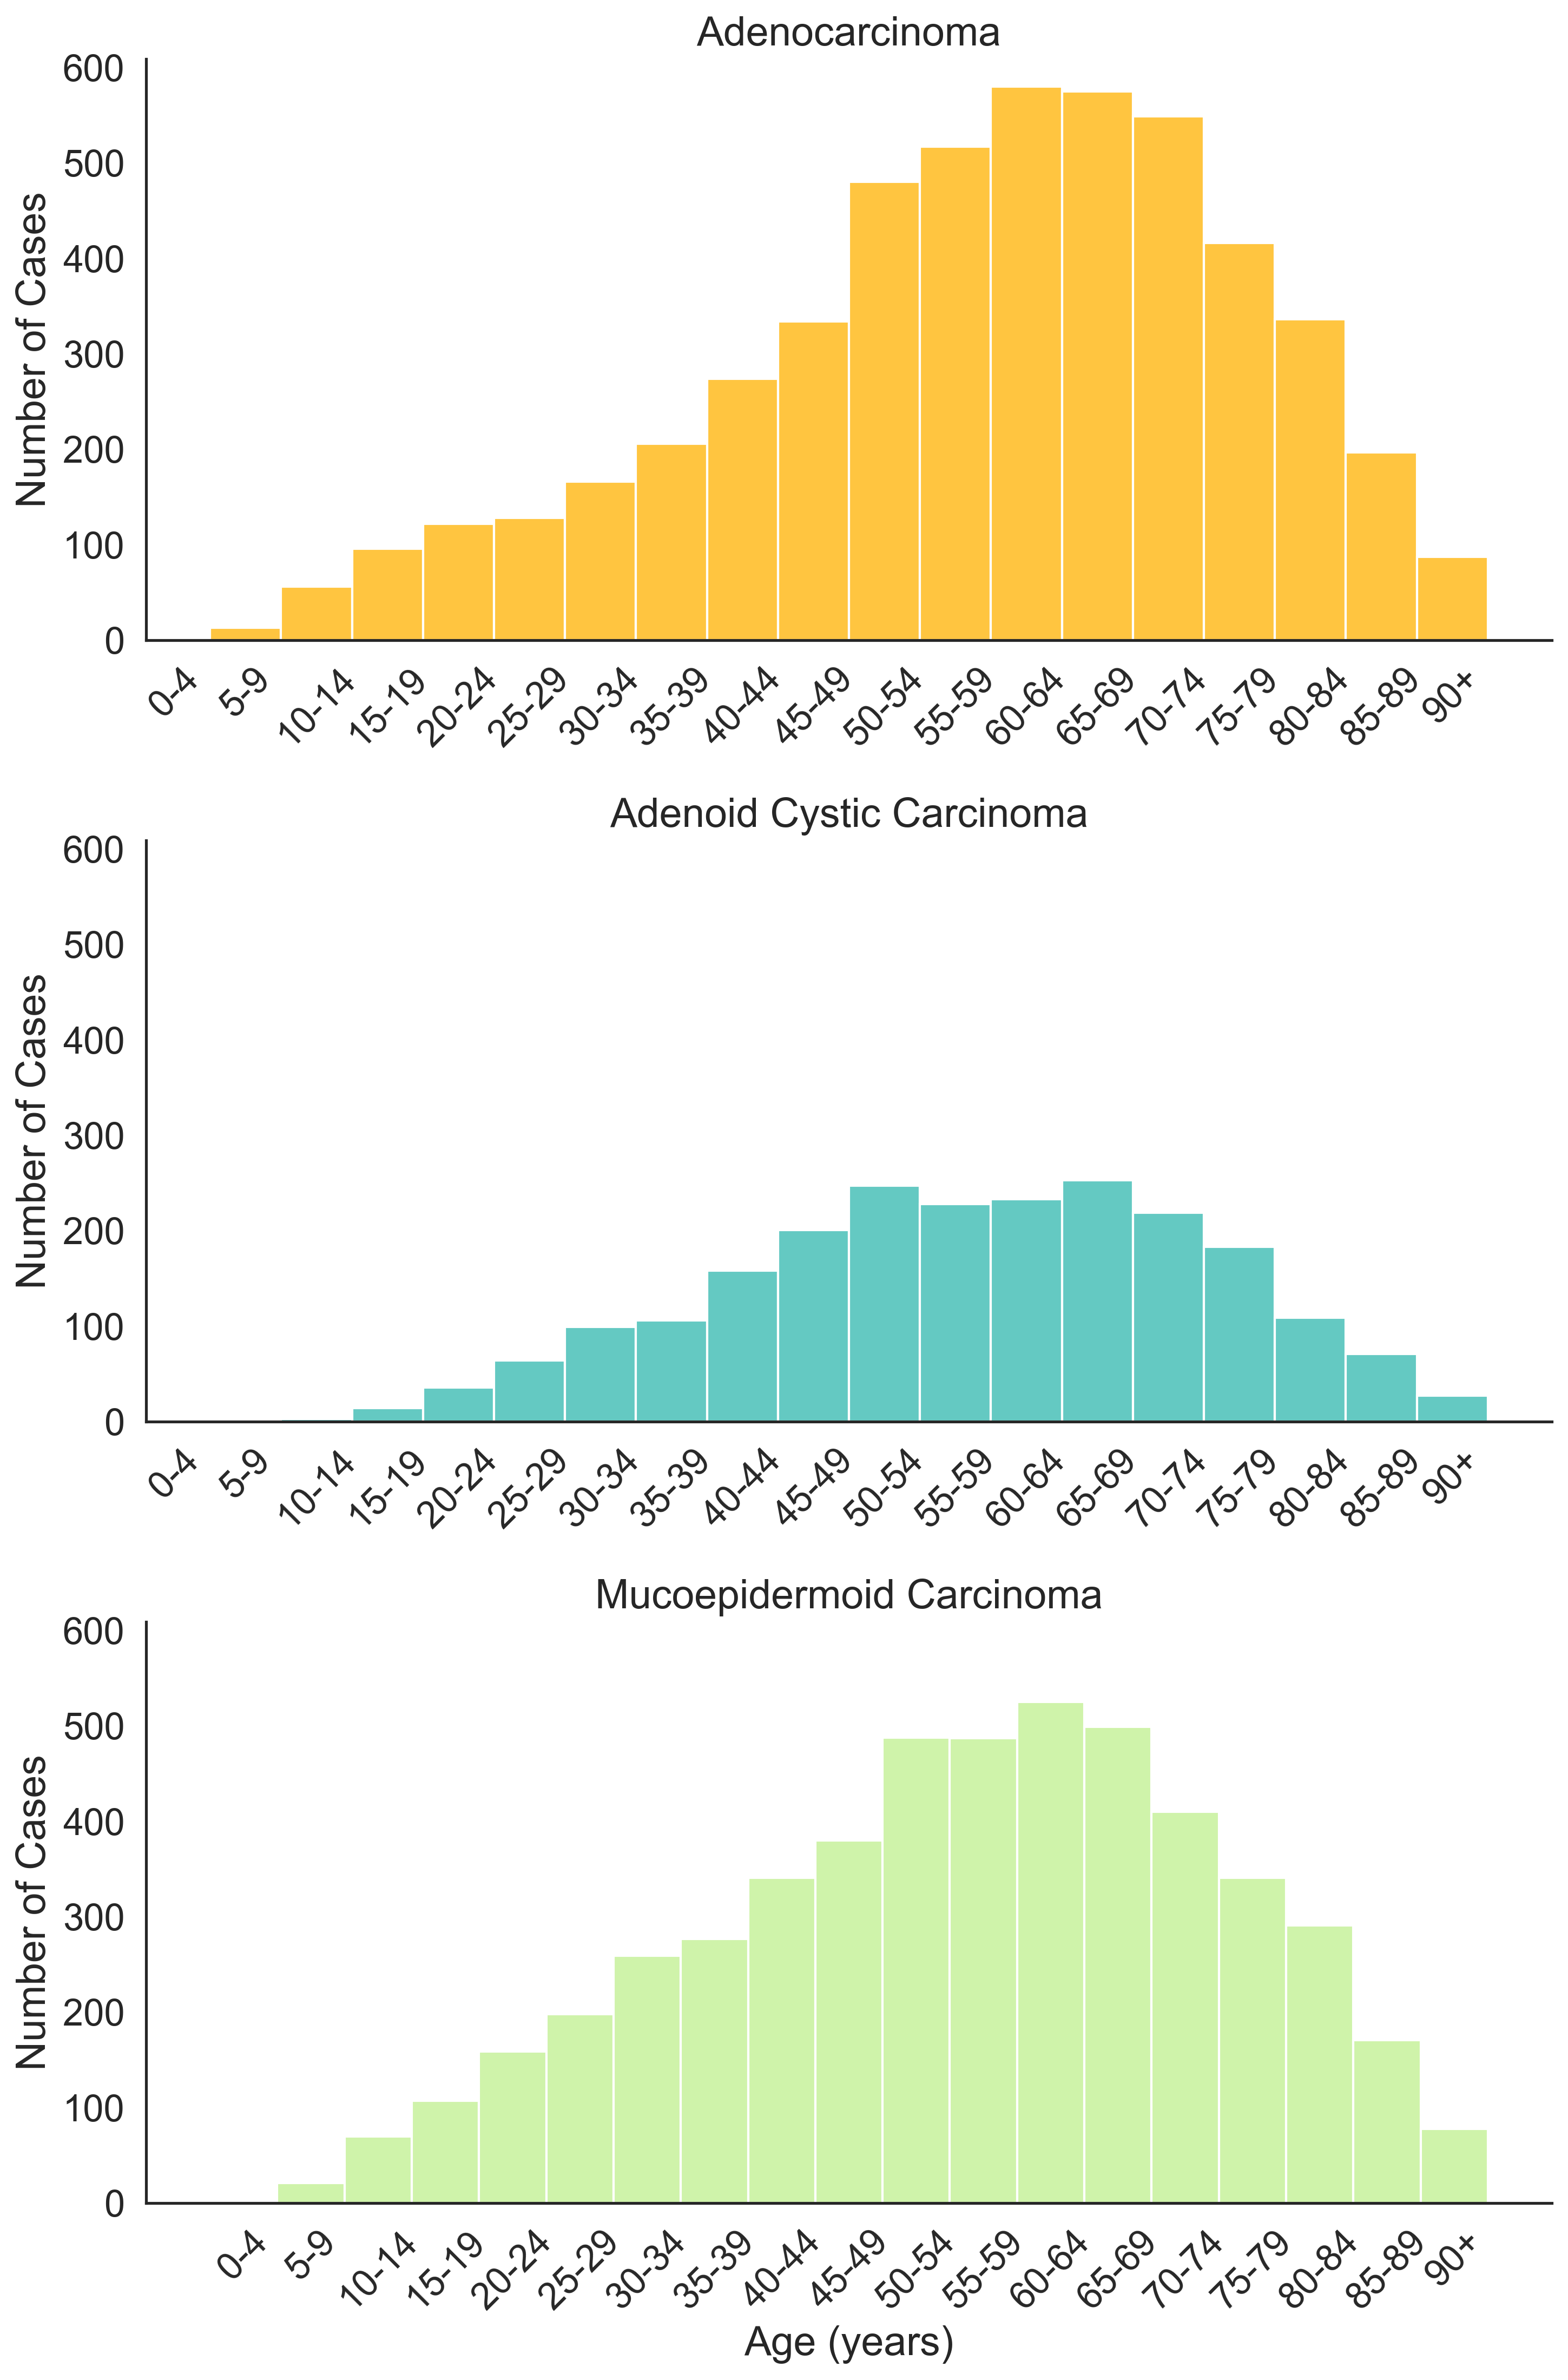

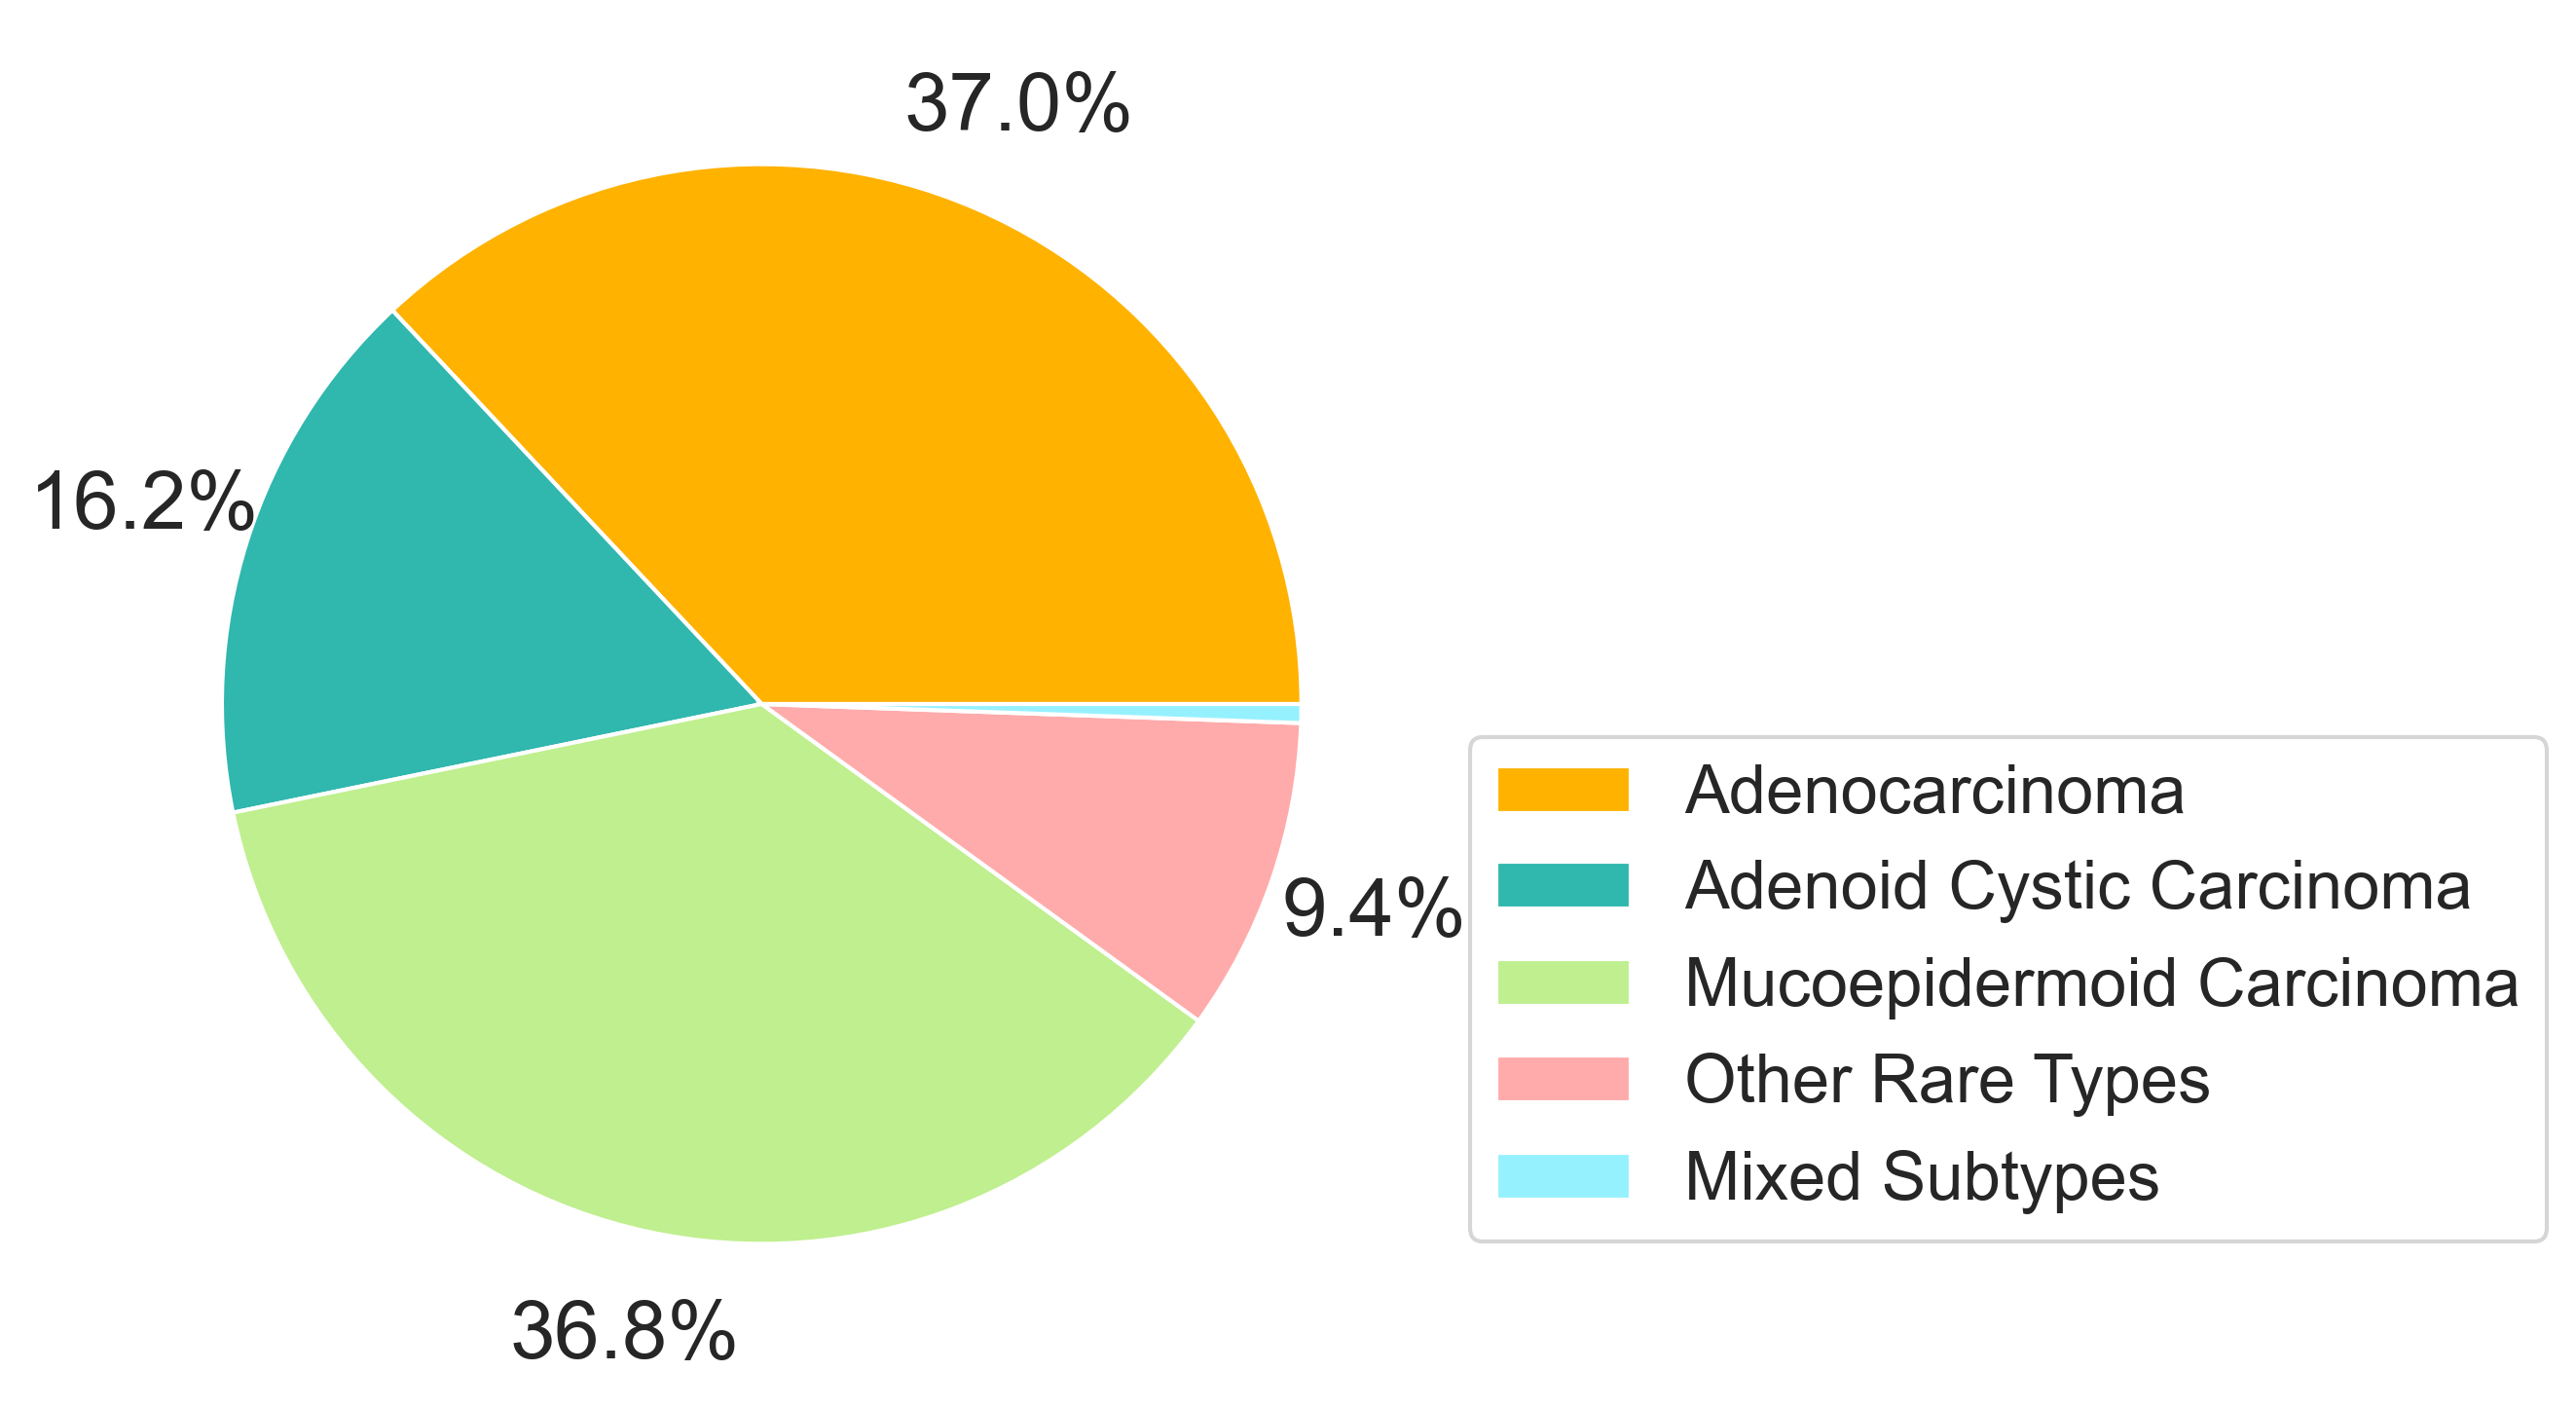

In [57]:
# Set the context for better visibility
sns.set_context("notebook", font_scale=1.5)

# Create a FacetGrid instead of using displot
g = sns.FacetGrid(filtered_df_forFacetGrid, col="Histology", col_wrap=1, height=5, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, x=age_bin_colname, binwidth=1, hue='Histology', palette=topNColorDict, multiple='stack')

# Rotate the x-tick labels in each facet
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set labels and titles
g.set_xlabels('Age (years)')
g.set_ylabels('Number of Cases')
g.set_titles(col_template="{col_name}")

# Set layout
plt.tight_layout()

# Save the Histology histograms
plt.savefig('histology_histograms.png', dpi=300, bbox_inches='tight')

plt.show()



# Calculate tumor site counts
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order

labels = tumor_type_counts.index

# Create pie chart
plt.figure(figsize=(8, 6))
# Explicit colors definition:
colors_for_pie = [fullColorDict[label] for label in ordered_labels if label in fullColorDict]
# Define a function as an input to autopct:
def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct >= 1 else ''

# Create the pie chart with specified font sizes
patches, texts, autotexts = plt.pie(
    ordered_counts, labels=None, autopct=autopct_format,
    pctdistance=1.2, colors=colors_for_pie
)

# Adjust the font size for the pie chart
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(20)

# Add legend
plt.legend(patches, ordered_labels, loc='best', bbox_to_anchor=(1, 0.5))

# Save the histology pie plot
plt.savefig('histology_pie.png', dpi=300, bbox_inches='tight')

plt.show()

## Cancer Types and Year of Diagnosis

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/143771924.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()


Year of diagnosis  Total Counts
16               2000           579
21               2001           517
19               2002           539
20               2003           518
14               2004           594
18               2005           572
13               2006           628
17               2007           573
7                2008           657
15               2009           588
12               2010           635
8                2011           655
6                2012           662
9                2013           652
11               2014           641
3                2015           695
5                2016           684
2                2017           695
0                2018           732
4                2019           691
10               2020           650
1                2021           716

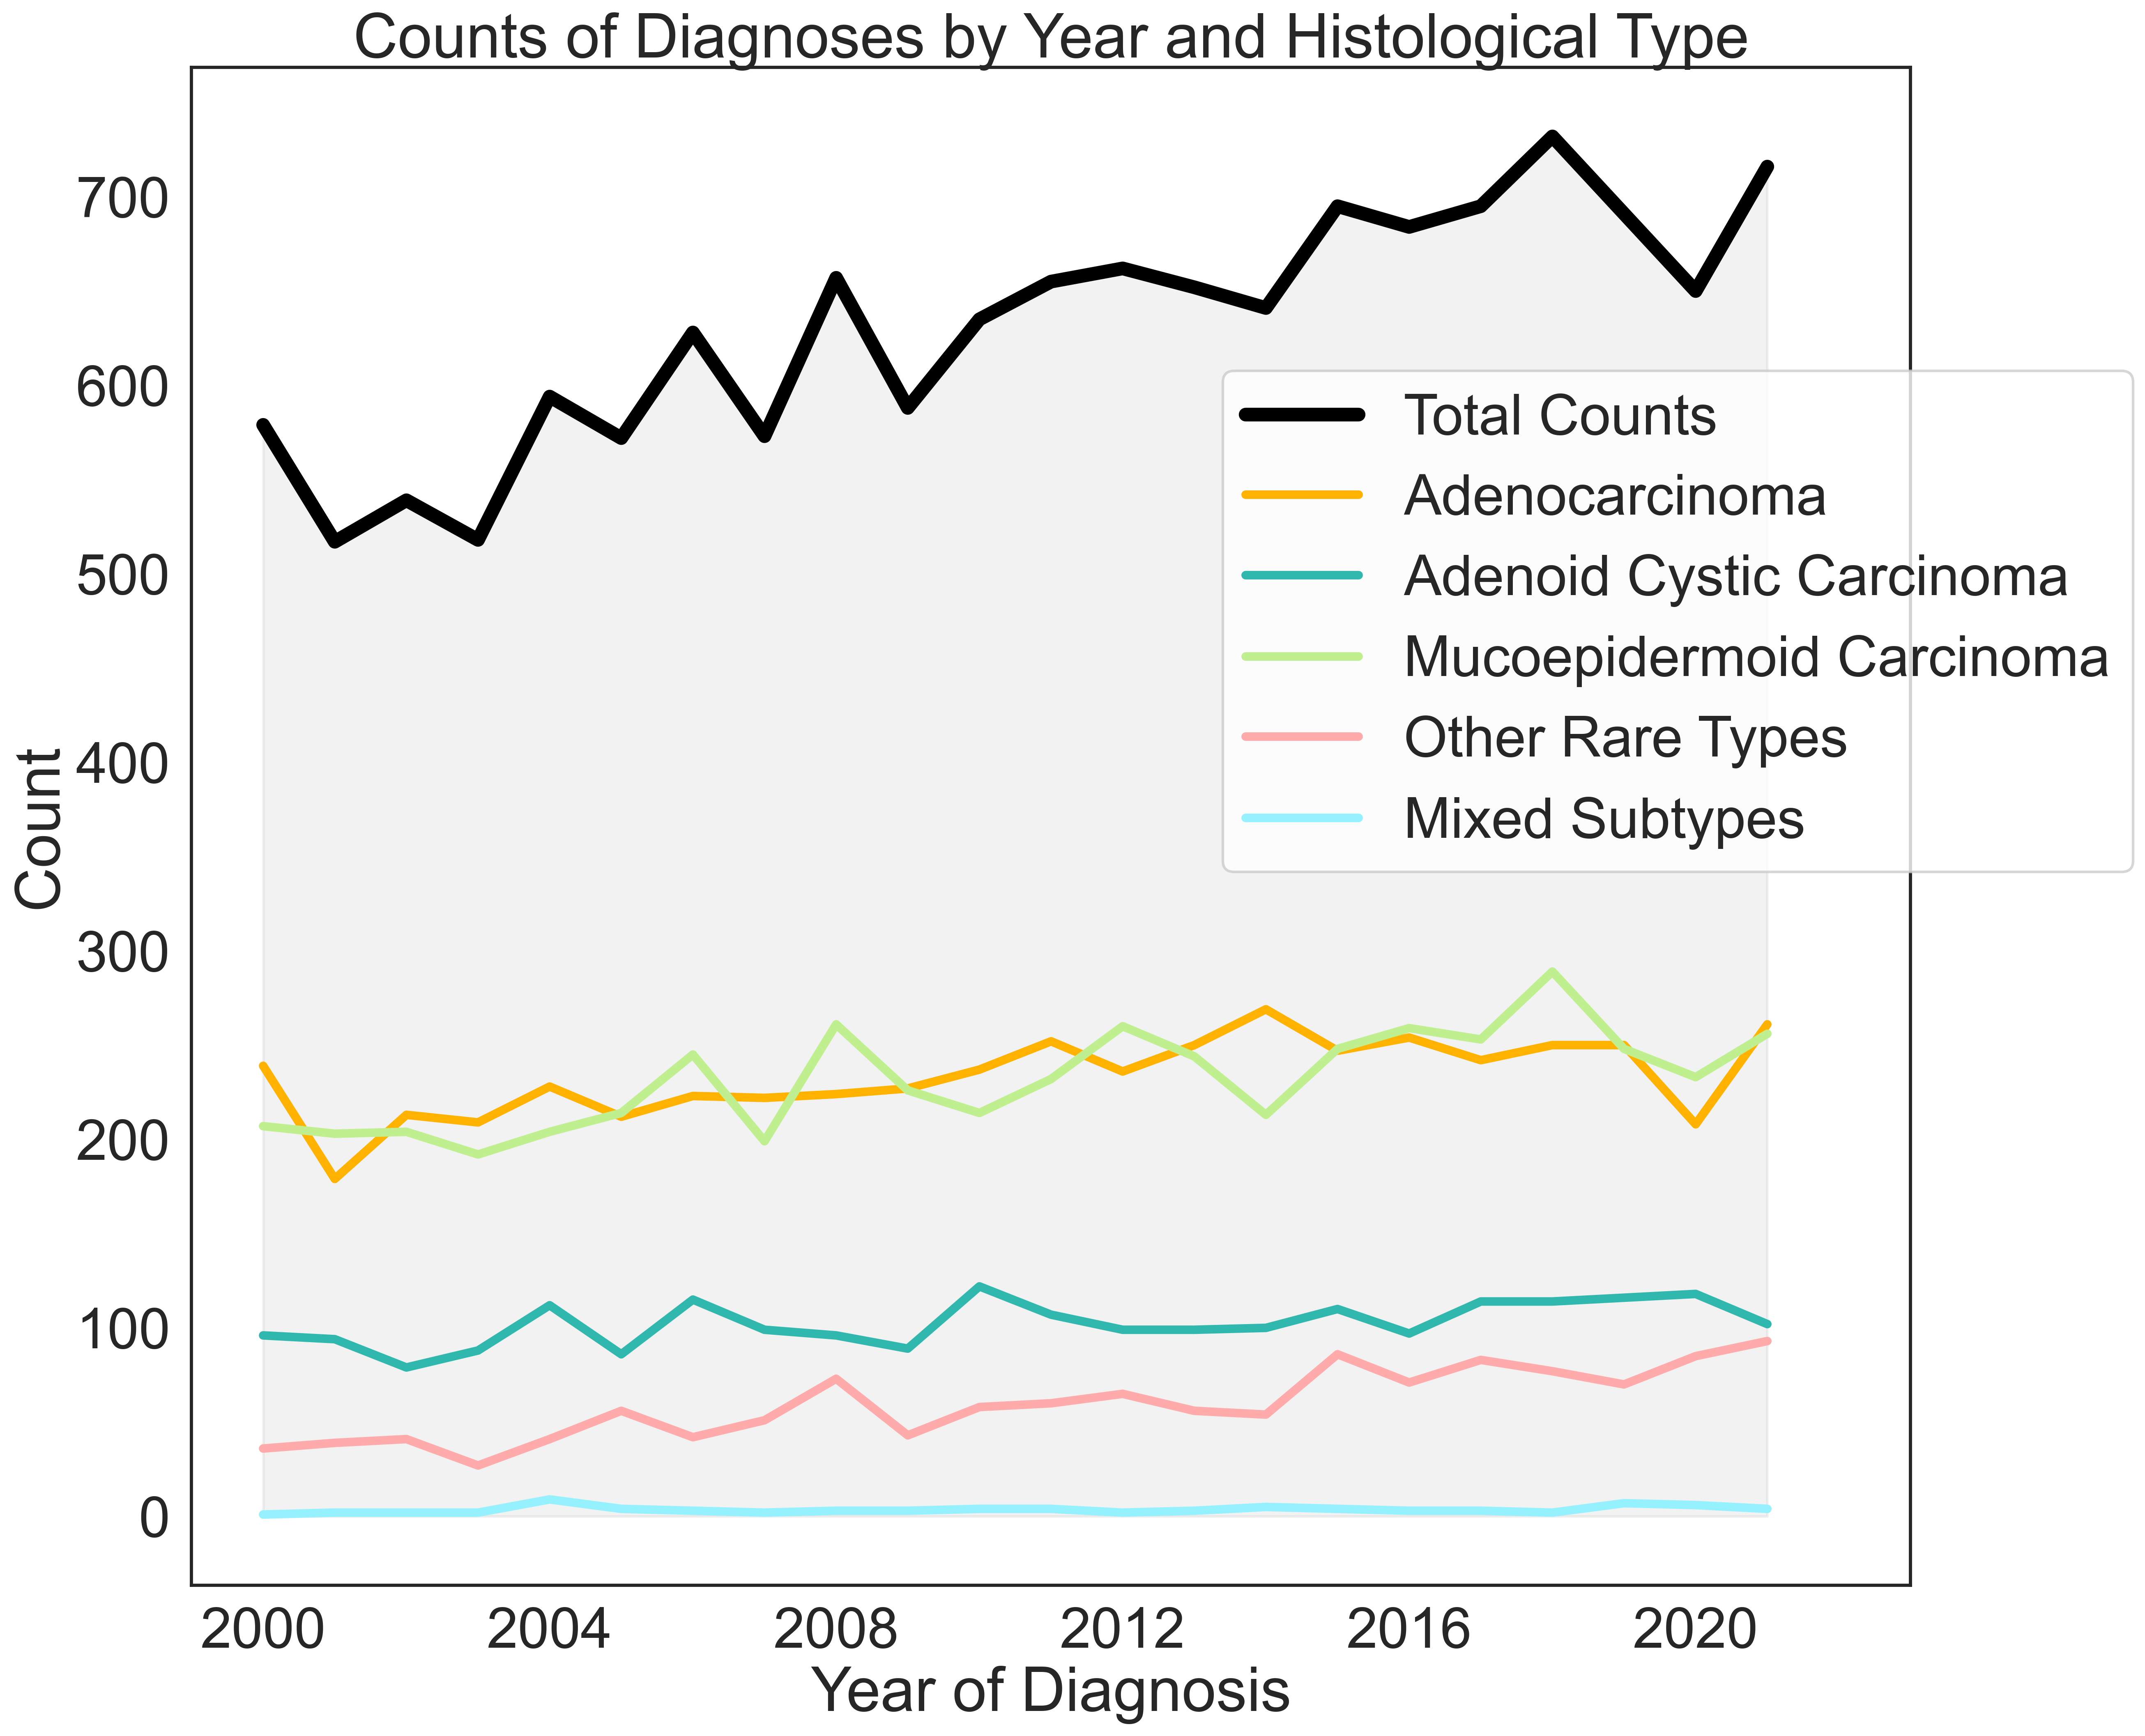

In [58]:
# Calculate counts per year per histological type.
type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()
type_year_counts_df = type_year_counts.reset_index(name='Counts')

# Calculate the counts per year for the bar plot
year_counts = filtered_df['Year of diagnosis'].value_counts()
year_counts_df = year_counts.reset_index(name='Total Counts')
year_counts_df.columns = ['Year of diagnosis', 'Total Counts']

# Ensure 'Year of diagnosis' is treated as an integer
year_counts_df['Year of diagnosis'] = year_counts_df['Year of diagnosis'].astype(int)
type_year_counts_df['Year of diagnosis'] = type_year_counts_df['Year of diagnosis'].astype(int)

# Sort both dataframes by 'Year of diagnosis' to ensure proper plotting order
year_counts_df = year_counts_df.sort_values('Year of diagnosis')
type_year_counts_df = type_year_counts_df.sort_values('Year of diagnosis')

# Display for verification
display(year_counts_df)

# Create plot and aesthetics
plt.figure(figsize=(18,16))
sns.set_context('talk', font_scale=2)

# Create the bar plot in the background for total counts per year
# sns.lineplot(year_counts_df,x='Year of diagnosis',y='Total Counts',
#              color=(0,0,0),lw=8,zorder=1,label='Total Count')
# Create the line plot for total counts per year
# We're using plt.plot instead of sns.lineplot to have more control over shading
plt.plot(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
         color='black', label='Total Counts', lw=8)

# Fill the area under the line with a shaded color
plt.fill_between(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
                 color='grey', alpha=0.1)

# Create line plot for each individual histological type
sns.lineplot(type_year_counts_df,x='Year of diagnosis',y='Counts',
             palette=colors,hue='Histology',lw=5,zorder=2)

# Adjust the x value limits
plt.xlim(1999,2023)
plt.xticks(range(2000,2022,4))
plt.grid(False, axis='y')
# Adjust legend position and add 'Total Counts' to the legend
plt.legend(bbox_to_anchor=(.6, .8), loc='upper left', borderaxespad=0.)

# Add labels and title
plt.xlabel('Year of Diagnosis')
plt.ylabel('Count')
plt.title('Counts of Diagnoses by Year and Histological Type')

plt.savefig('counts_vs_year.png', dpi=300, bbox_inches='tight')
plt.show()

# Age, Race, and Sex Proportions & Distributions

## Generate Excel files

In [59]:
# Calculate counts (value_counts with normalized=False) and sort (sort_index())
colsForTables = [age_bin_colname,sex_colname,race_colname,ses_colname,'Income_quartile',marital_colname,site_colname,'Grade Label','Grade Level']
# Create an Excel writer object and specify the file path
output_file_path = 'merged_tables.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for col in colsForTables:
        counts = (filtered_df[col].
                  value_counts(normalize=False).
                  sort_index())

        # Calculate proportions (normalized=True), sort (sort_index()), convert to indices
        proportions = (filtered_df[col].
                       value_counts(normalize=True).
                       sort_index())

        # Merge the counts and proportions into one table
        merged_table = pd.DataFrame({'Counts': counts, 'Proportions': proportions})
        print(merged_table)
        # Write each DataFrame to a different sheet
        merged_table.to_excel(writer, sheet_name=col[:30])

        # Create a pivot table for counts
        counts_table = filtered_df.pivot_table(
            index=col,      # Rows (e.g., Age)
            columns='Histology',        # Columns (e.g., Histology categories)
            aggfunc='size',            # Aggregation function (count in this case)
            fill_value=0                # Fill missing values with 0
        )

        counts_table.to_excel(writer, sheet_name=col[:20]+'_wide')

    
print(f"Merged tables exported to {output_file_path}")

            Counts  Proportions
Age_Binned                     
0-4              2     0.000144
5-9             35     0.002523
10-14          129     0.009299
15-19          221     0.015930
20-24          330     0.023787
25-29          412     0.029698
30-34          547     0.039429
35-39          628     0.045268
40-44          819     0.059036
45-49         1008     0.072659
50-54         1311     0.094500
55-59         1348     0.097167
60-64         1487     0.107187
65-69         1518     0.109421
70-74         1369     0.098681
75-79         1102     0.079435
80-84          854     0.061558
85-89          524     0.037771
90+            229     0.016507
        Counts  Proportions
Sex                        
Female    7202     0.519138
Male      6671     0.480862
                                Counts  Proportions
Race recode (W, B, AI, API)                        
White                            10739     0.779714
Black                             1479     0.107384
Asian or

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/995036149.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/995036149.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/995036149.py:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var

# Survival Analysis

### Data Preparation and Clinical Column Identification

In [60]:
# Select relevant columns for clinical characteristics analysis
clinical_columns = ['Primary Site - labeled', 'Histologic Type ICD-O-3',
                     'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
                     'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Grade Label', 'Laterality',
                     'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
                     'ICD-O-3 Hist/behav, malignant','Histology','ICD-O-3 Code','SEER cause-specific death classification',
                    'SEER other cause of death classification', 'Survival months',
                    'Survival months flag', 'COD to site rec KM',
                    'COD to site recode ICD-O-3 2023 Revision',
                    'COD to site recode ICD-O-3 2023 Revision Expanded (1999+)',
                    'Vital status recode (study cutoff used)', 'Sequence number',
                    'First malignant primary indicator', 'Primary by international rules']

# Creating a summary for clinical characteristics
clinical_summary = filtered_df[clinical_columns]

# Display the summary
# display(clinical_summary)

vital_percentages = clinical_summary["Vital status recode (study cutoff used)"].value_counts(normalize=True) * 100
alive_percentage = vital_percentages["Alive"]
dead_percentage = vital_percentages["Dead"]

print(vital_percentages)

Vital status recode (study cutoff used)
Alive    64.362431
Dead     35.637569
Name: proportion, dtype: float64


## Kaplan Meier Survival Curves:
## Histology Based KMs

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/709769579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


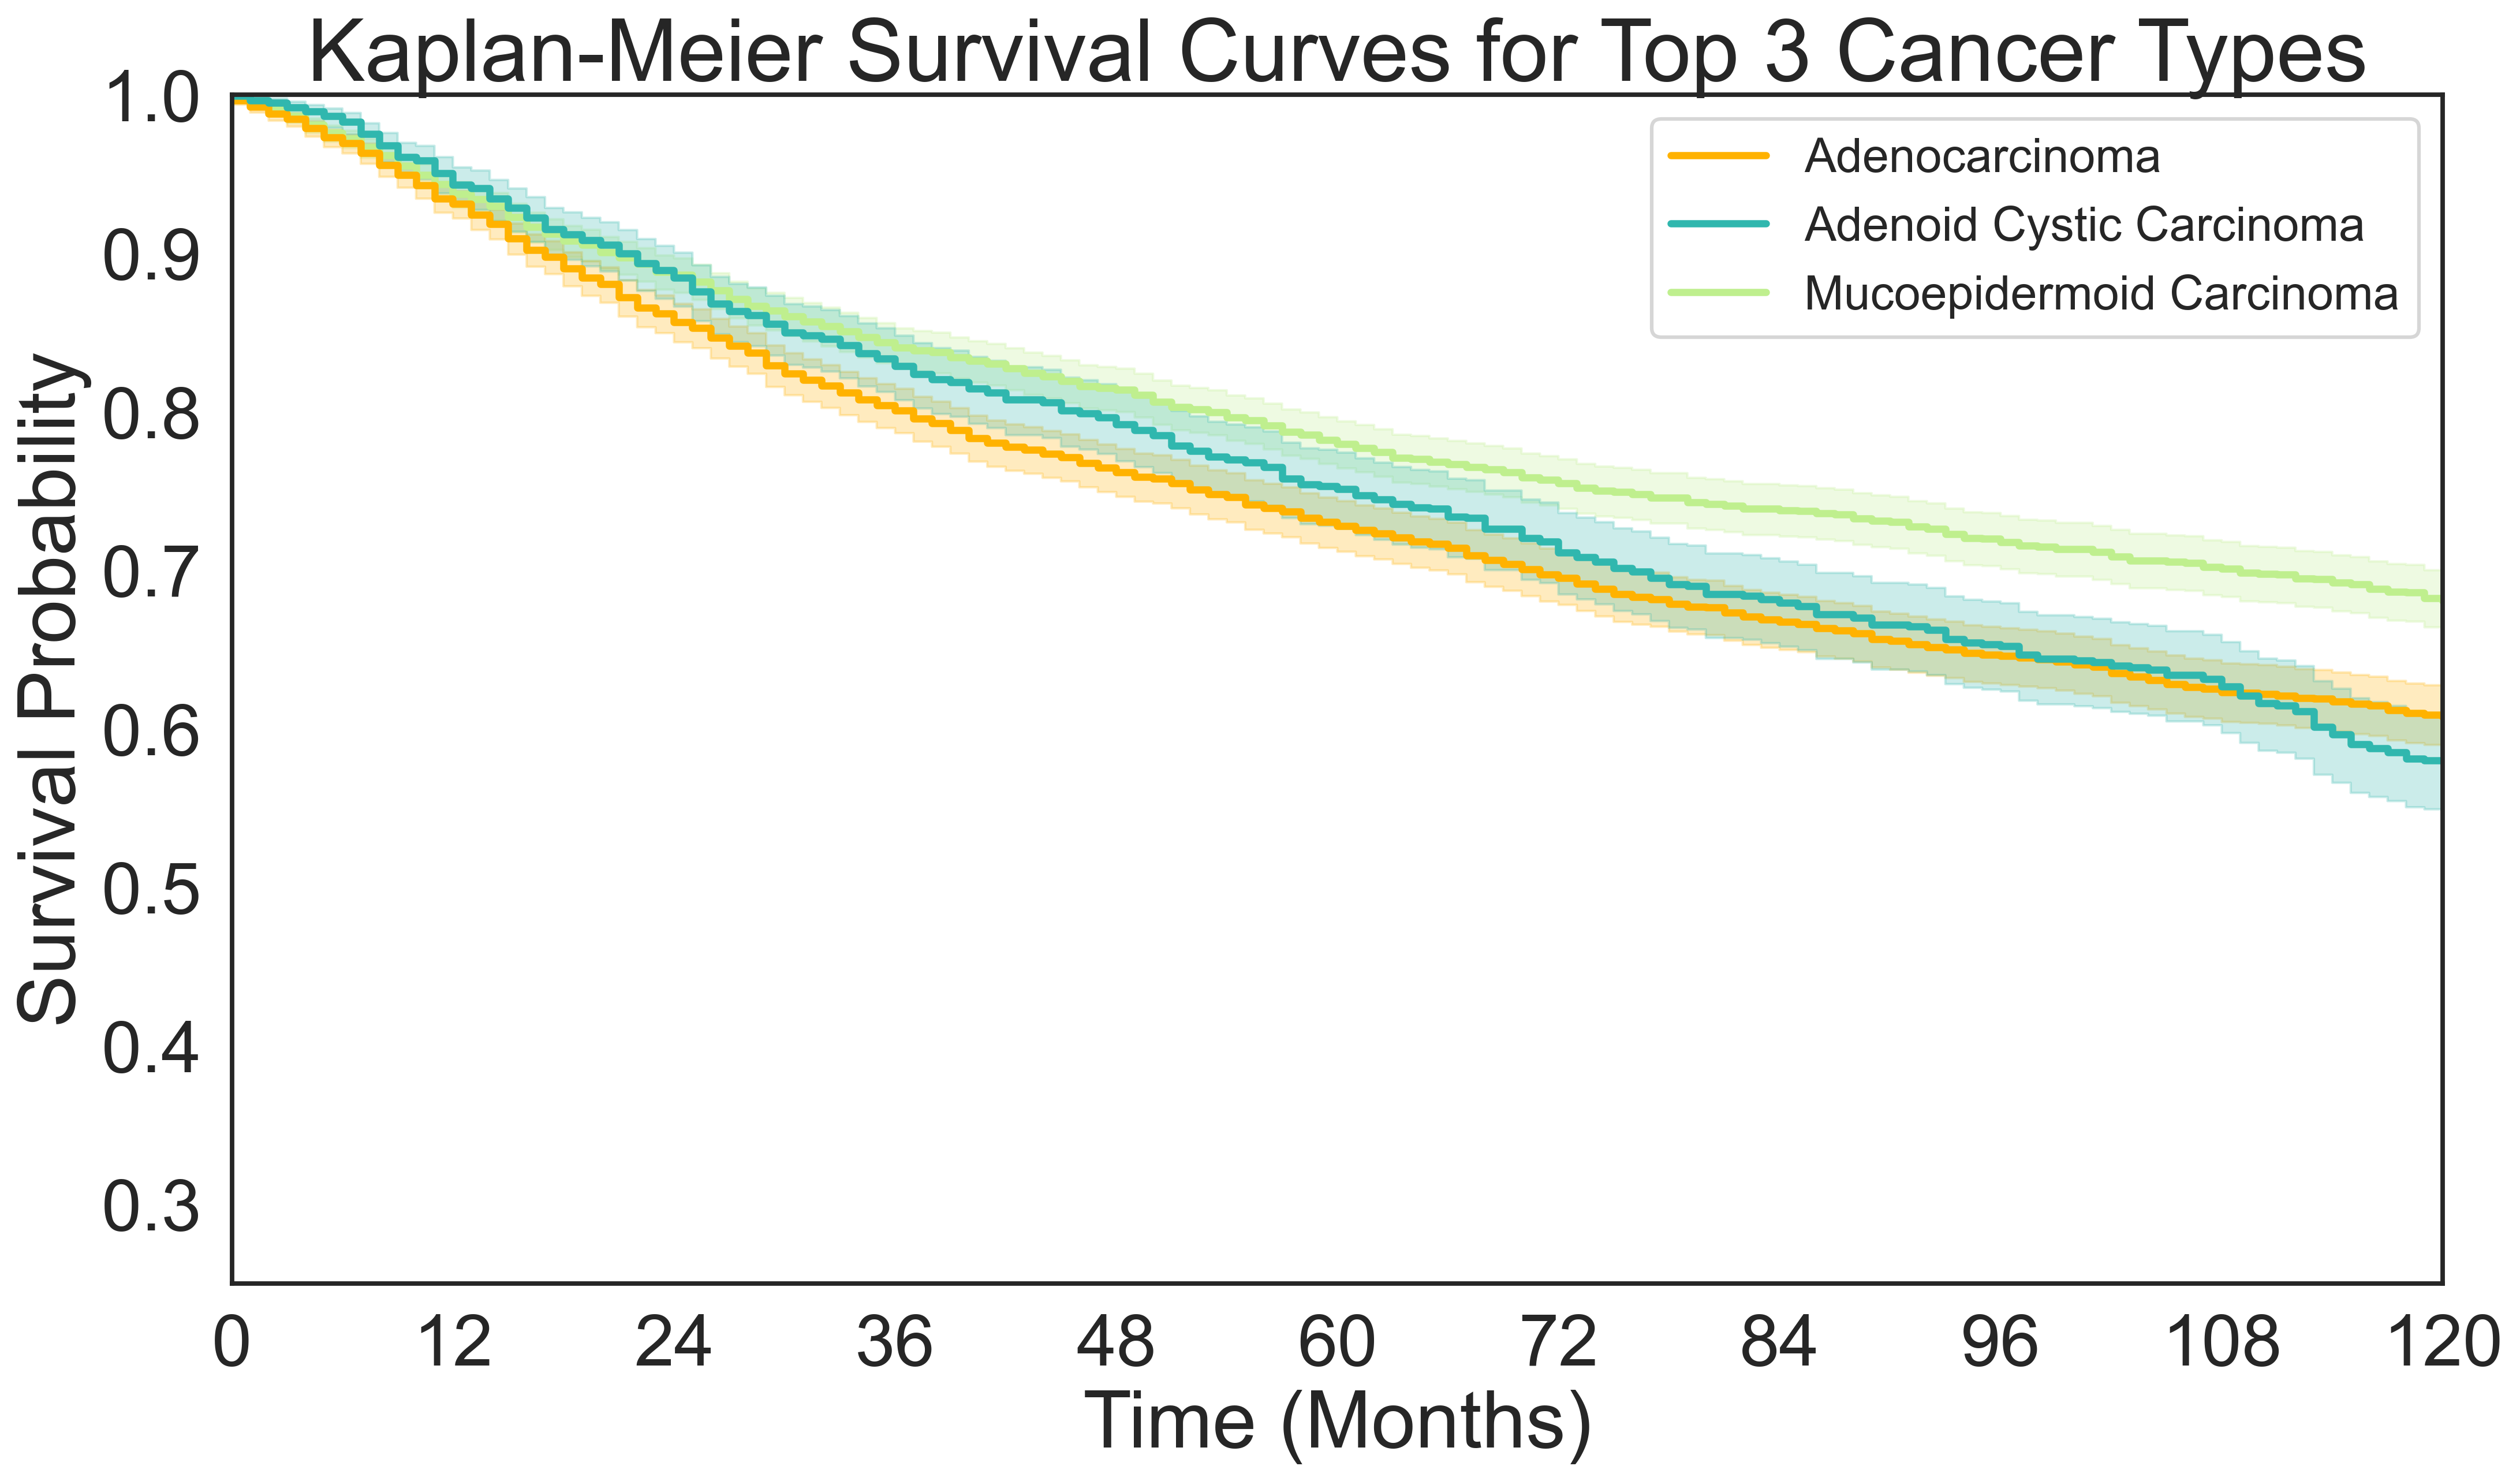

In [79]:
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
# else 2 if x == 'Dead (missing/unknown COD)'
else 0)

# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique cancer types in your dataset
cancer_types = df['Histology'].unique()

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for cancer_type in cancer_types:
    # Filter the DataFrame for each cancer type
    df_cancer = df[df['Histology'] == cancer_type]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_cancer['Survival months'], event_observed=df_cancer['event_occurred'], label=cancer_type)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=topNColorDict[cancer_type])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Top 3 Cancer Types', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = topCancerTypes

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Race Based KMs

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_99324/1050420270.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


<class 'pandas.core.frame.DataFrame'>
Index: 8366 entries, 6 to 28015
Data columns (total 73 columns):
 #   Column                                                     Non-Null Count  Dtype   
---  ------                                                     --------------  -----   
 0   Patient ID                                                 8366 non-null   int64   
 1   Age recode with <1 year olds                               8366 non-null   object  
 2   Sex                                                        8366 non-null   category
 3   Year of diagnosis                                          8366 non-null   int64   
 4   PRCDA 2020                                                 8366 non-null   object  
 5   Race recode (W, B, AI, API)                                8366 non-null   category
 6   Origin recode NHIA (Hispanic, Non-Hisp)                    8366 non-null   object  
 7   Site recode ICD-O-3/WHO 2008                               8366 non-null   object  
 8   Be

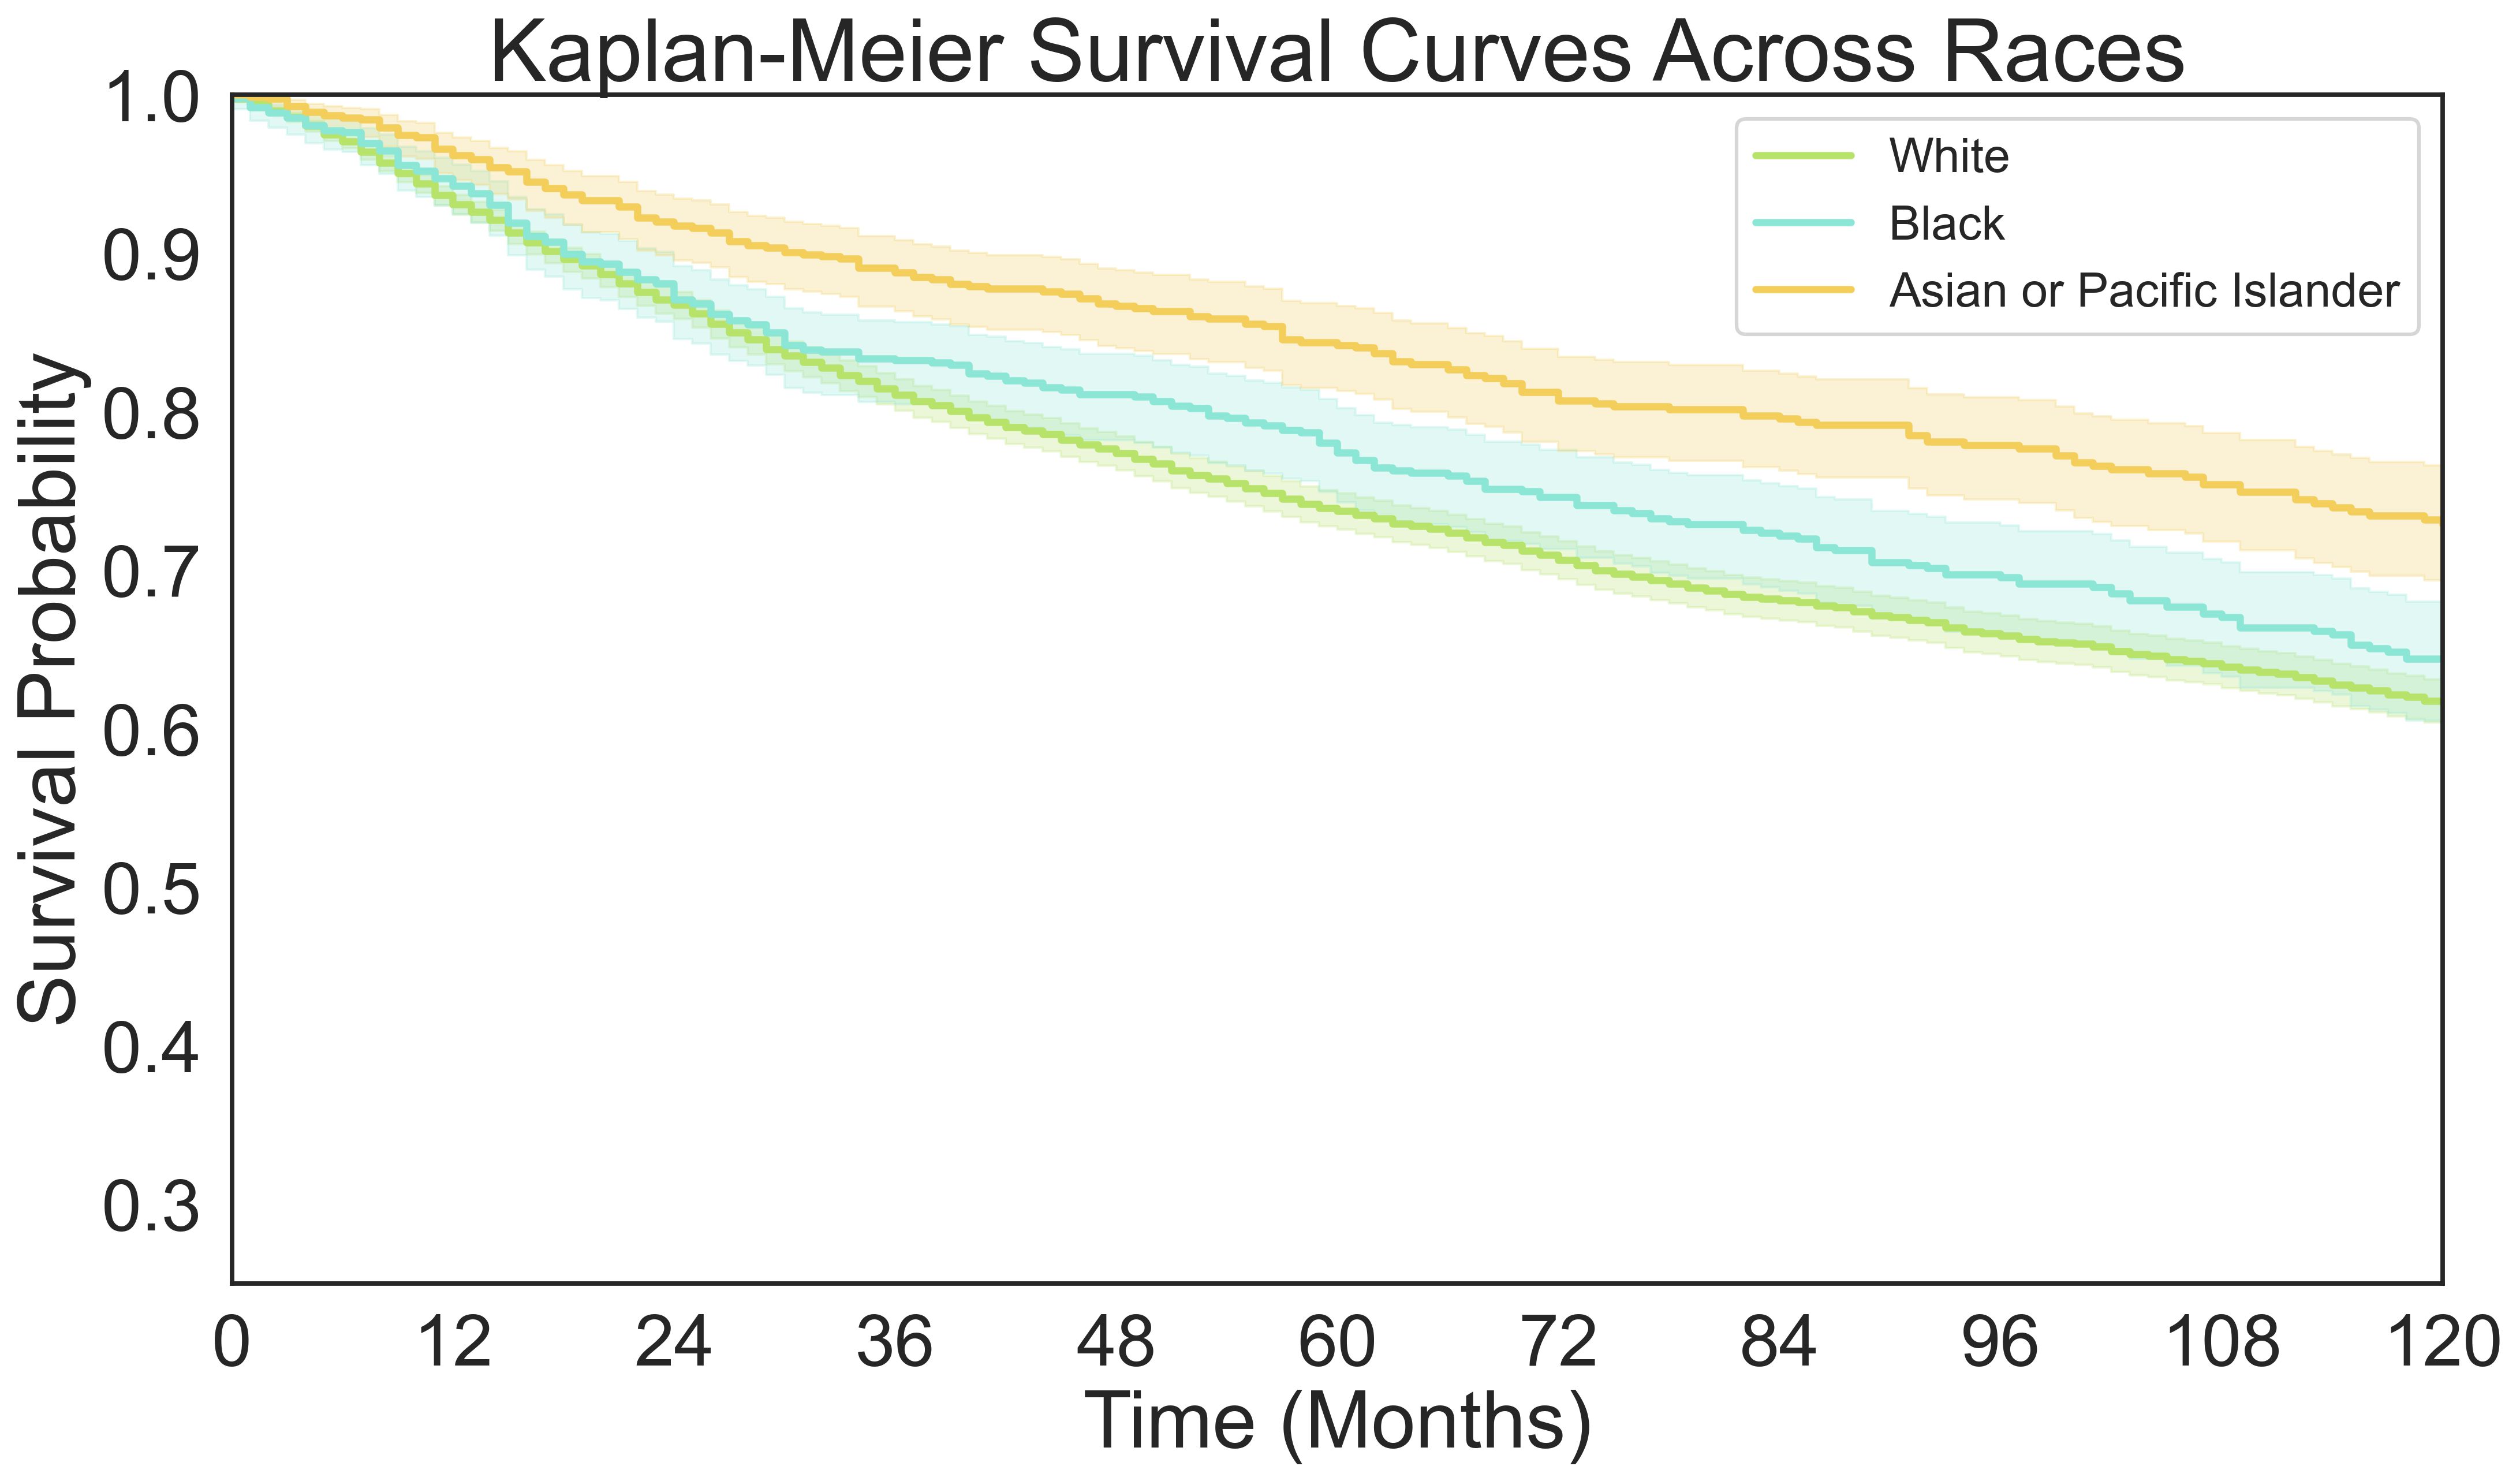

In [80]:
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
    # else 2 if x == 'Dead (missing/unknown COD)'
    else 0)

# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()
df.info()

all_races = df['Race recode (W, B, AI, API)'].unique()
main_races = ['White', 'Black', 'Asian or Pacific Islander']

df = df[df['Race recode (W, B, AI, API)'].isin(main_races)]
df['Race recode (W, B, AI, API)'] = df['Race recode (W, B, AI, API)'].cat.remove_unused_categories()
df['Race recode (W, B, AI, API)'] = df['Race recode (W, B, AI, API)'].cat.reorder_categories(['Asian or Pacific Islander','Black','White'], ordered=True)

# Make new color dictionary
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors
raceColorDict = {race: color for race, color in zip(main_races, race_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for race in main_races:
    # Filter the DataFrame for each cancer type
    df_race = df[df['Race recode (W, B, AI, API)'] == race]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_race['Survival months'], event_observed=df_race['event_occurred'], label=race)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=raceColorDict[race])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves Across Races', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = main_races

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()



## SES Based KMs


6        Upper middle quartile
9             Highest quartile
10            Highest quartile
16       Upper middle quartile
17       Upper middle quartile
                 ...          
28000          Lowest quartile
28005          Lowest quartile
28009    Lower middle quartile
28014    Lower middle quartile
28015    Lower middle quartile
Name: Income_quartile, Length: 8285, dtype: category
Categories (4, object): ['Highest quartile' < 'Upper middle quartile' < 'Lower middle quartile' < 'Lowest quartile']


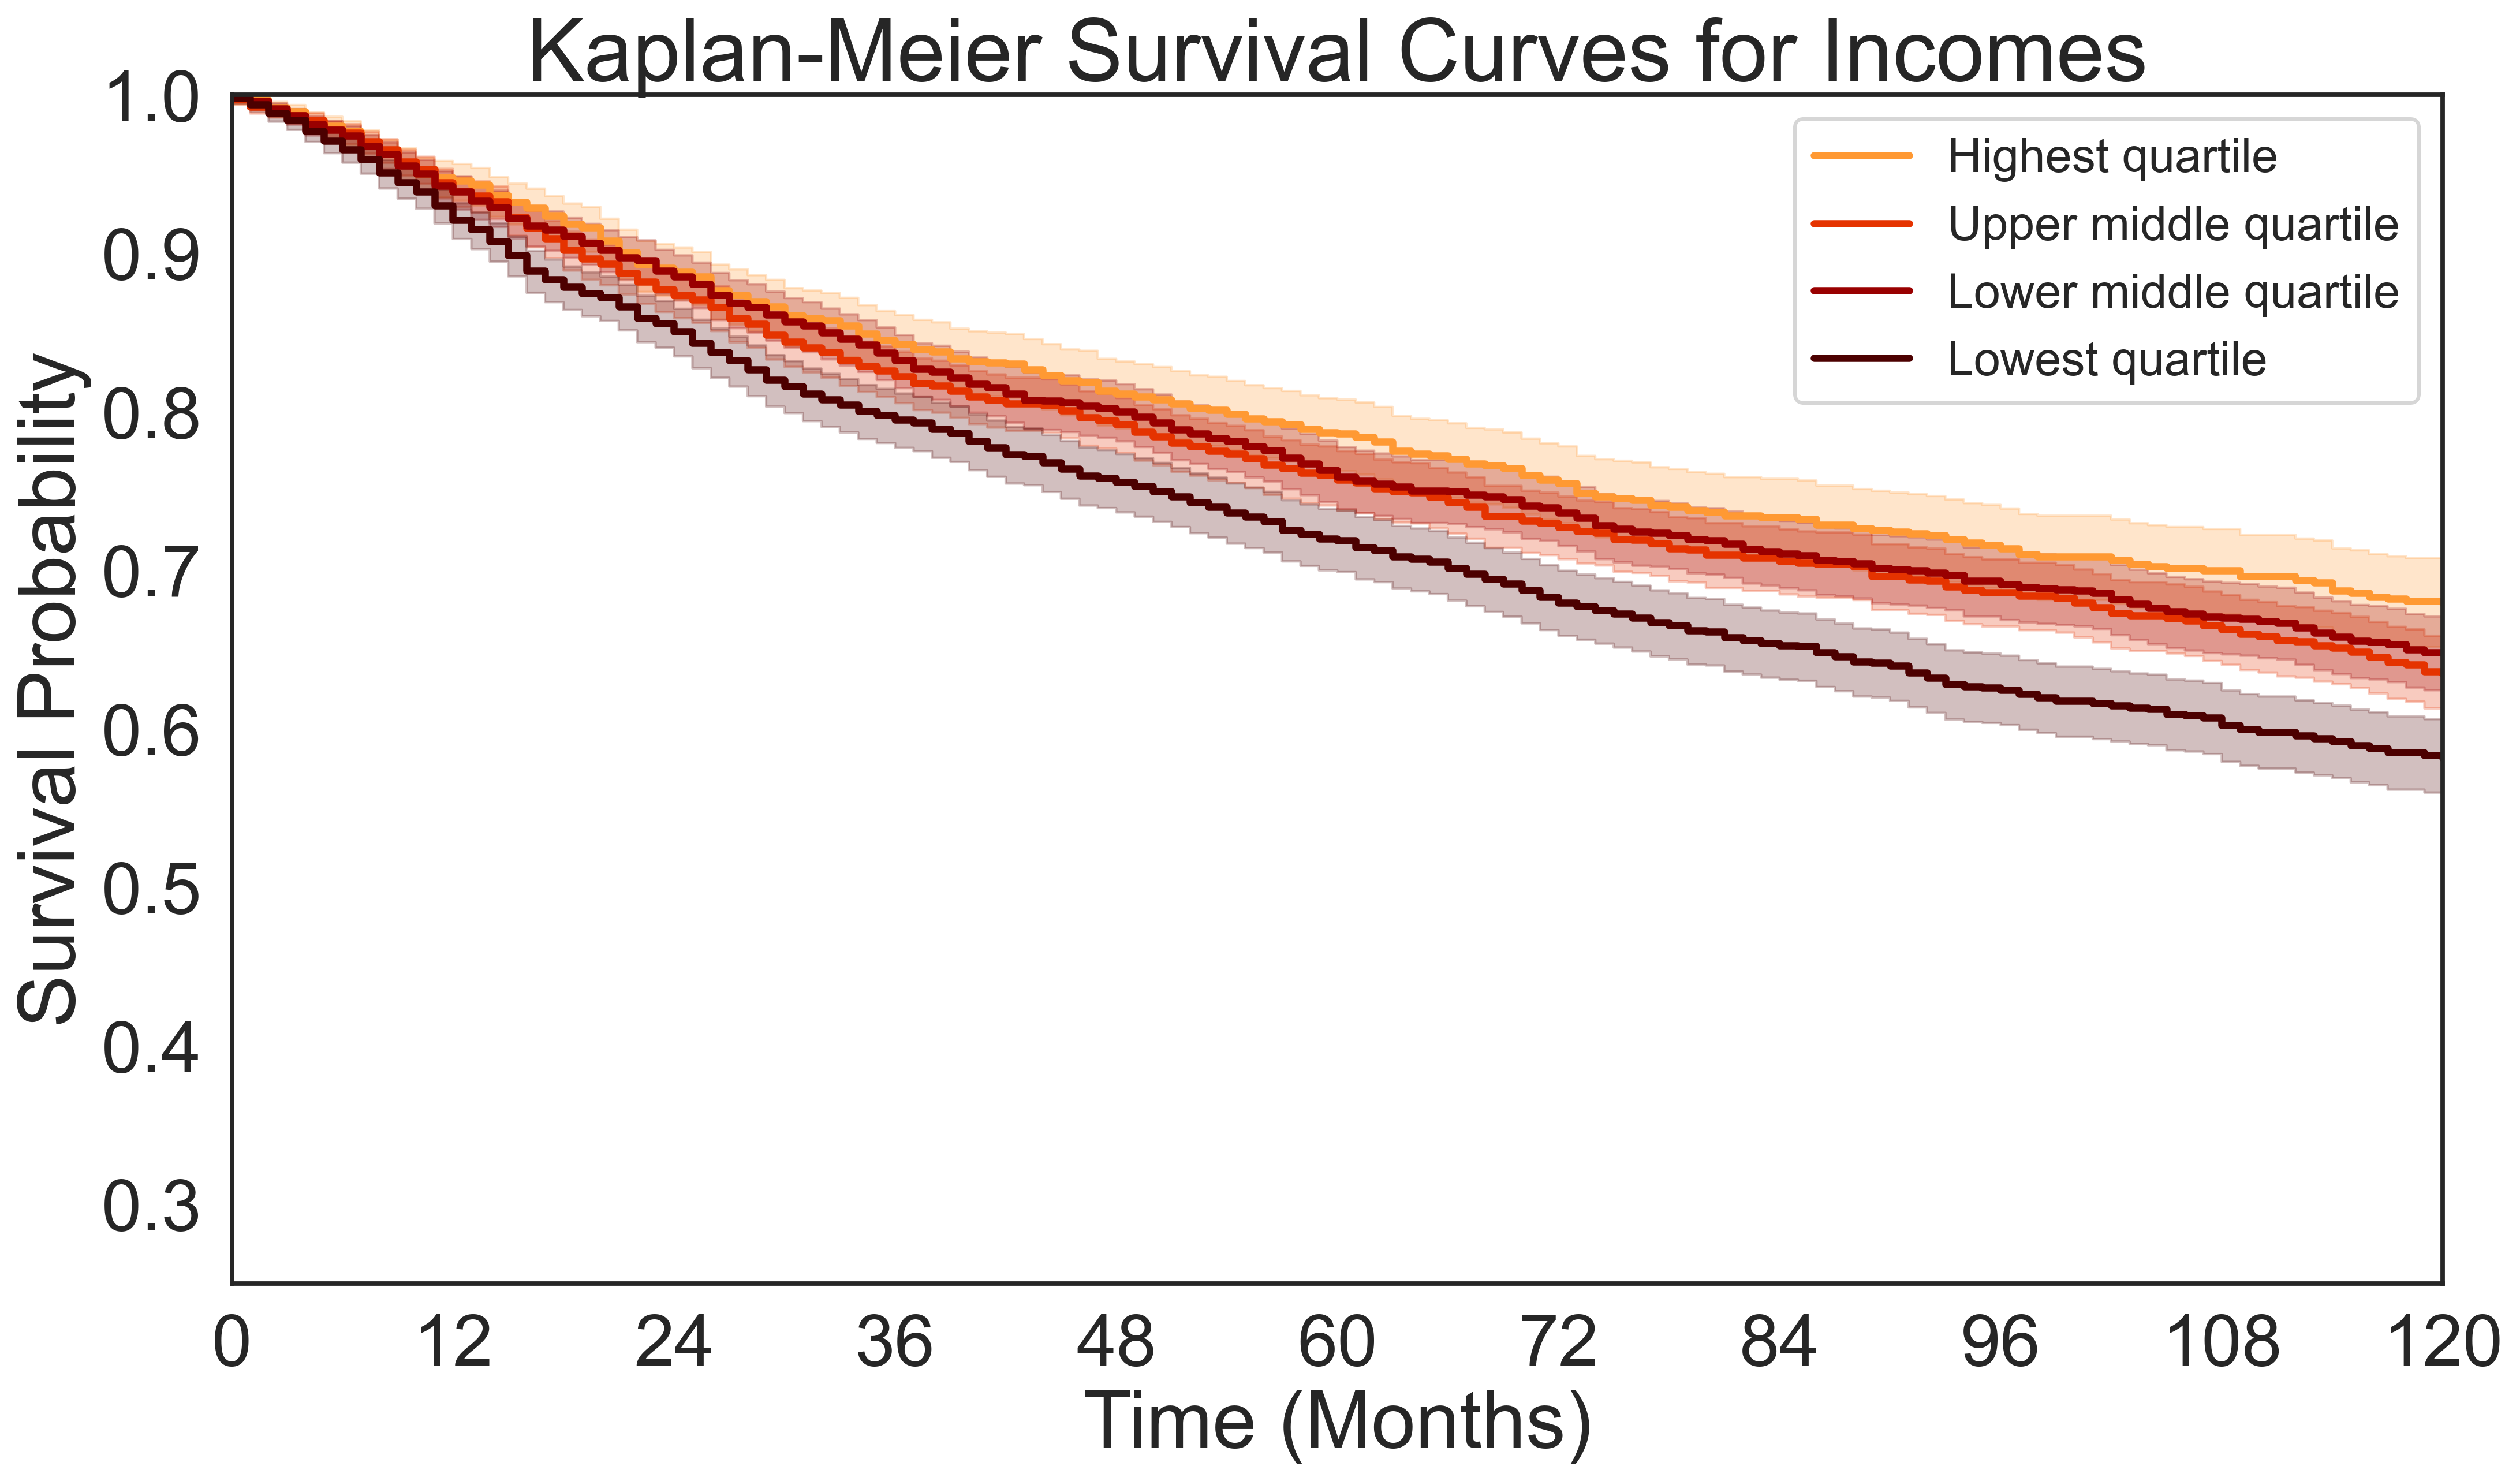

In [81]:
# First let's split the incomes into quartiles
income_col = 'Median household income inflation adj to 2022'

# # Define a function to extract numerical values from median income
# def extract_midpoint(income_str):
#     # Check if the income string represents an open-ended range (e.g., "$120,000+")
#     income_str = income_str.replace(',','')
#     if '+' in income_str:
#         # Extract the number before the '+' and return it as a float
#         return float(re.sub(r'[^\d]', '', income_str))
# 
#     # Check if the income string represents a range (e.g., "$40,000 - $44,999")
#     elif '-' in income_str:
#         # Extract the two numbers and calculate the midpoint
#         numbers = re.findall(r'\d+', income_str)
#         lower_bound = float(numbers[0])
#         upper_bound = float(numbers[1])
#         midpoint = (lower_bound + upper_bound) / 2
#         return midpoint
# 
#     # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
#     elif '<' in income_str:
#         # Extract the number and treat it as the threshold value
#         return float(re.sub(r'[^\d]', '', income_str))
# 
#     # If the string does not match any of the patterns, return NaN
#     return np.nan

# Apply the function to the income column
df['Income_numeric'] = df['Median household income inflation adj to 2022'].apply(extract_midpoint)
df['Income_numeric'] = df['Income_numeric'].astype('double')
# Step 3: Create a new column with quartile assignments
df['Income_quartile'] = pd.qcut(df['Income_numeric'], q=4, labels=["Lowest quartile", "Lower middle quartile", "Upper middle quartile", "Highest quartile"])
df['Income_quartile'] = df['Income_quartile'].cat.reorder_categories(['Highest quartile','Upper middle quartile','Lower middle quartile','Lowest quartile'],ordered=True)
print(df['Income_quartile'])
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset
income_types = df['Income_quartile'].cat.categories


# Make new color dictionary
incomeColorDict = {income_status: color for income_status, color in zip(income_types, ses_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for income_status in income_types:
    # Filter the DataFrame for each cancer type
    df_income = df[df['Income_quartile'] == income_status]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_income['Survival months'], event_observed=df_income['event_occurred'], label=income_status)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=incomeColorDict[income_status])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Incomes', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = income_types

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Sex Based KMs

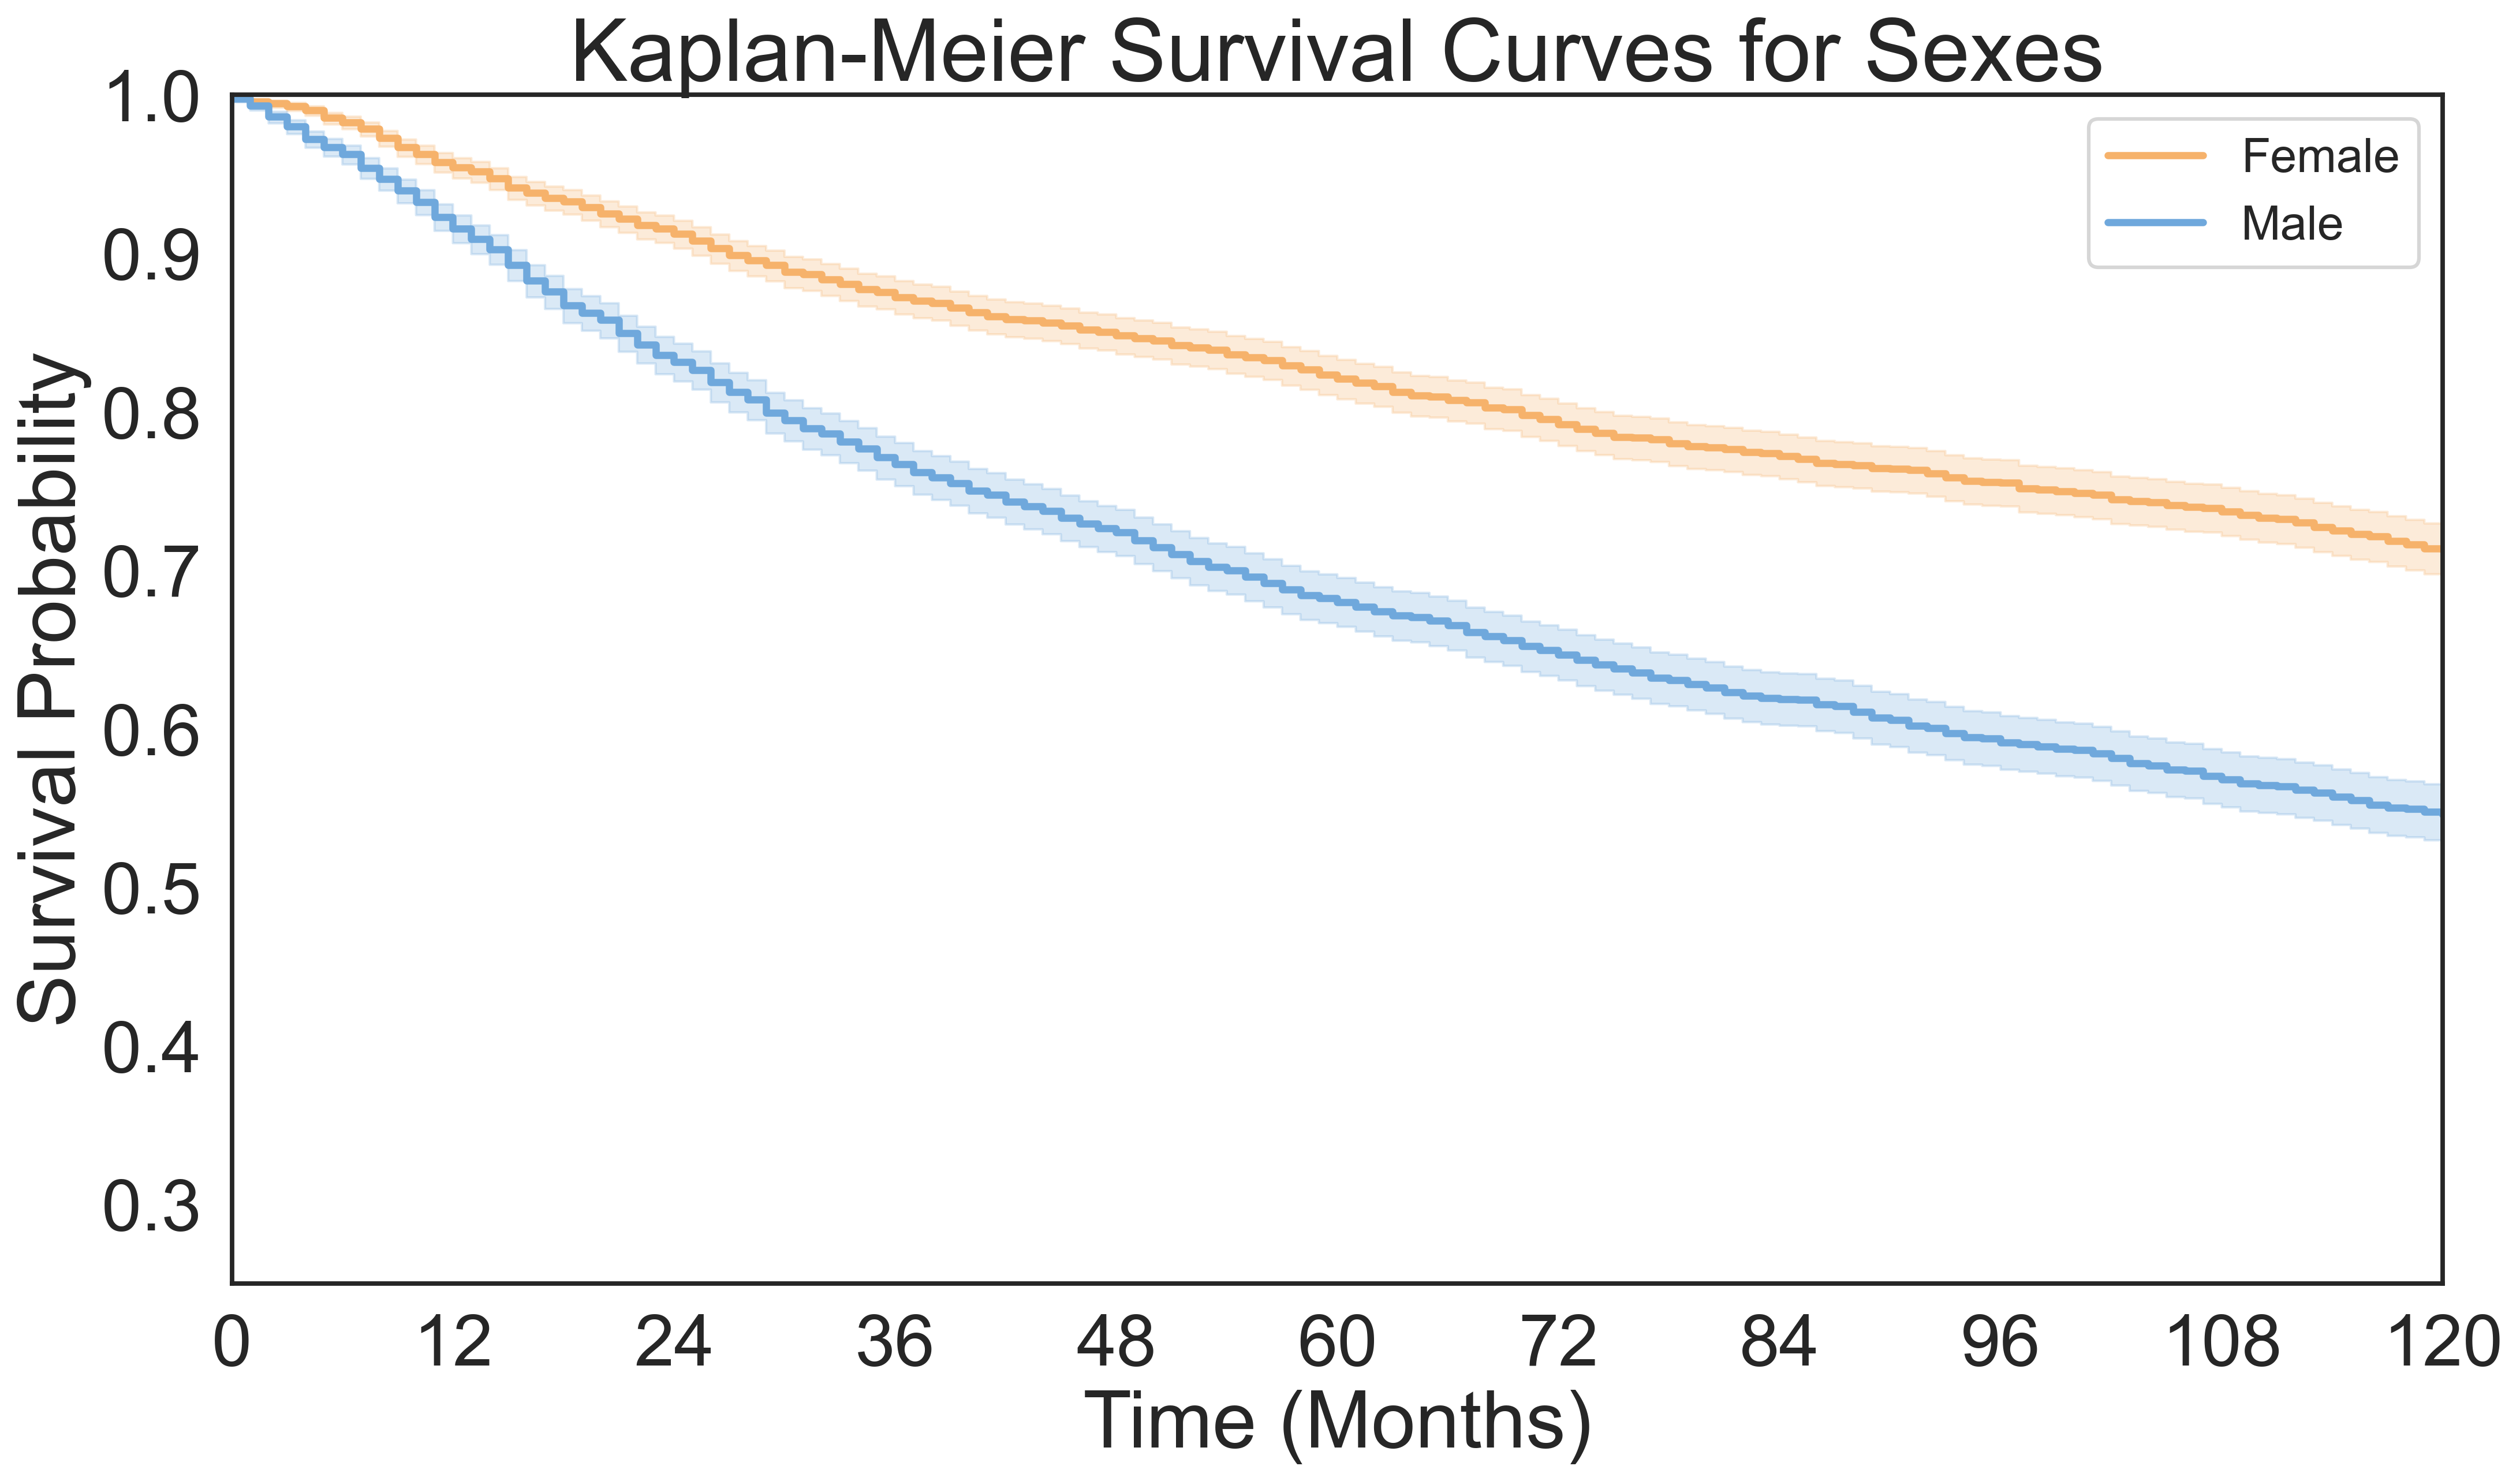

In [82]:

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset
sex_values = df['Sex'].cat.categories

# Make new color dictionary
sexColorDict = {sex: color for sex, color in zip(sex_values, sex_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for sex in sex_values:
    # Filter the DataFrame for each cancer type
    df_sex = df[df['Sex'] == sex]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_sex['Survival months'], event_observed=df_sex['event_occurred'], label=sex)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=sexColorDict[sex])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Sexes', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = sex_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Marital Status

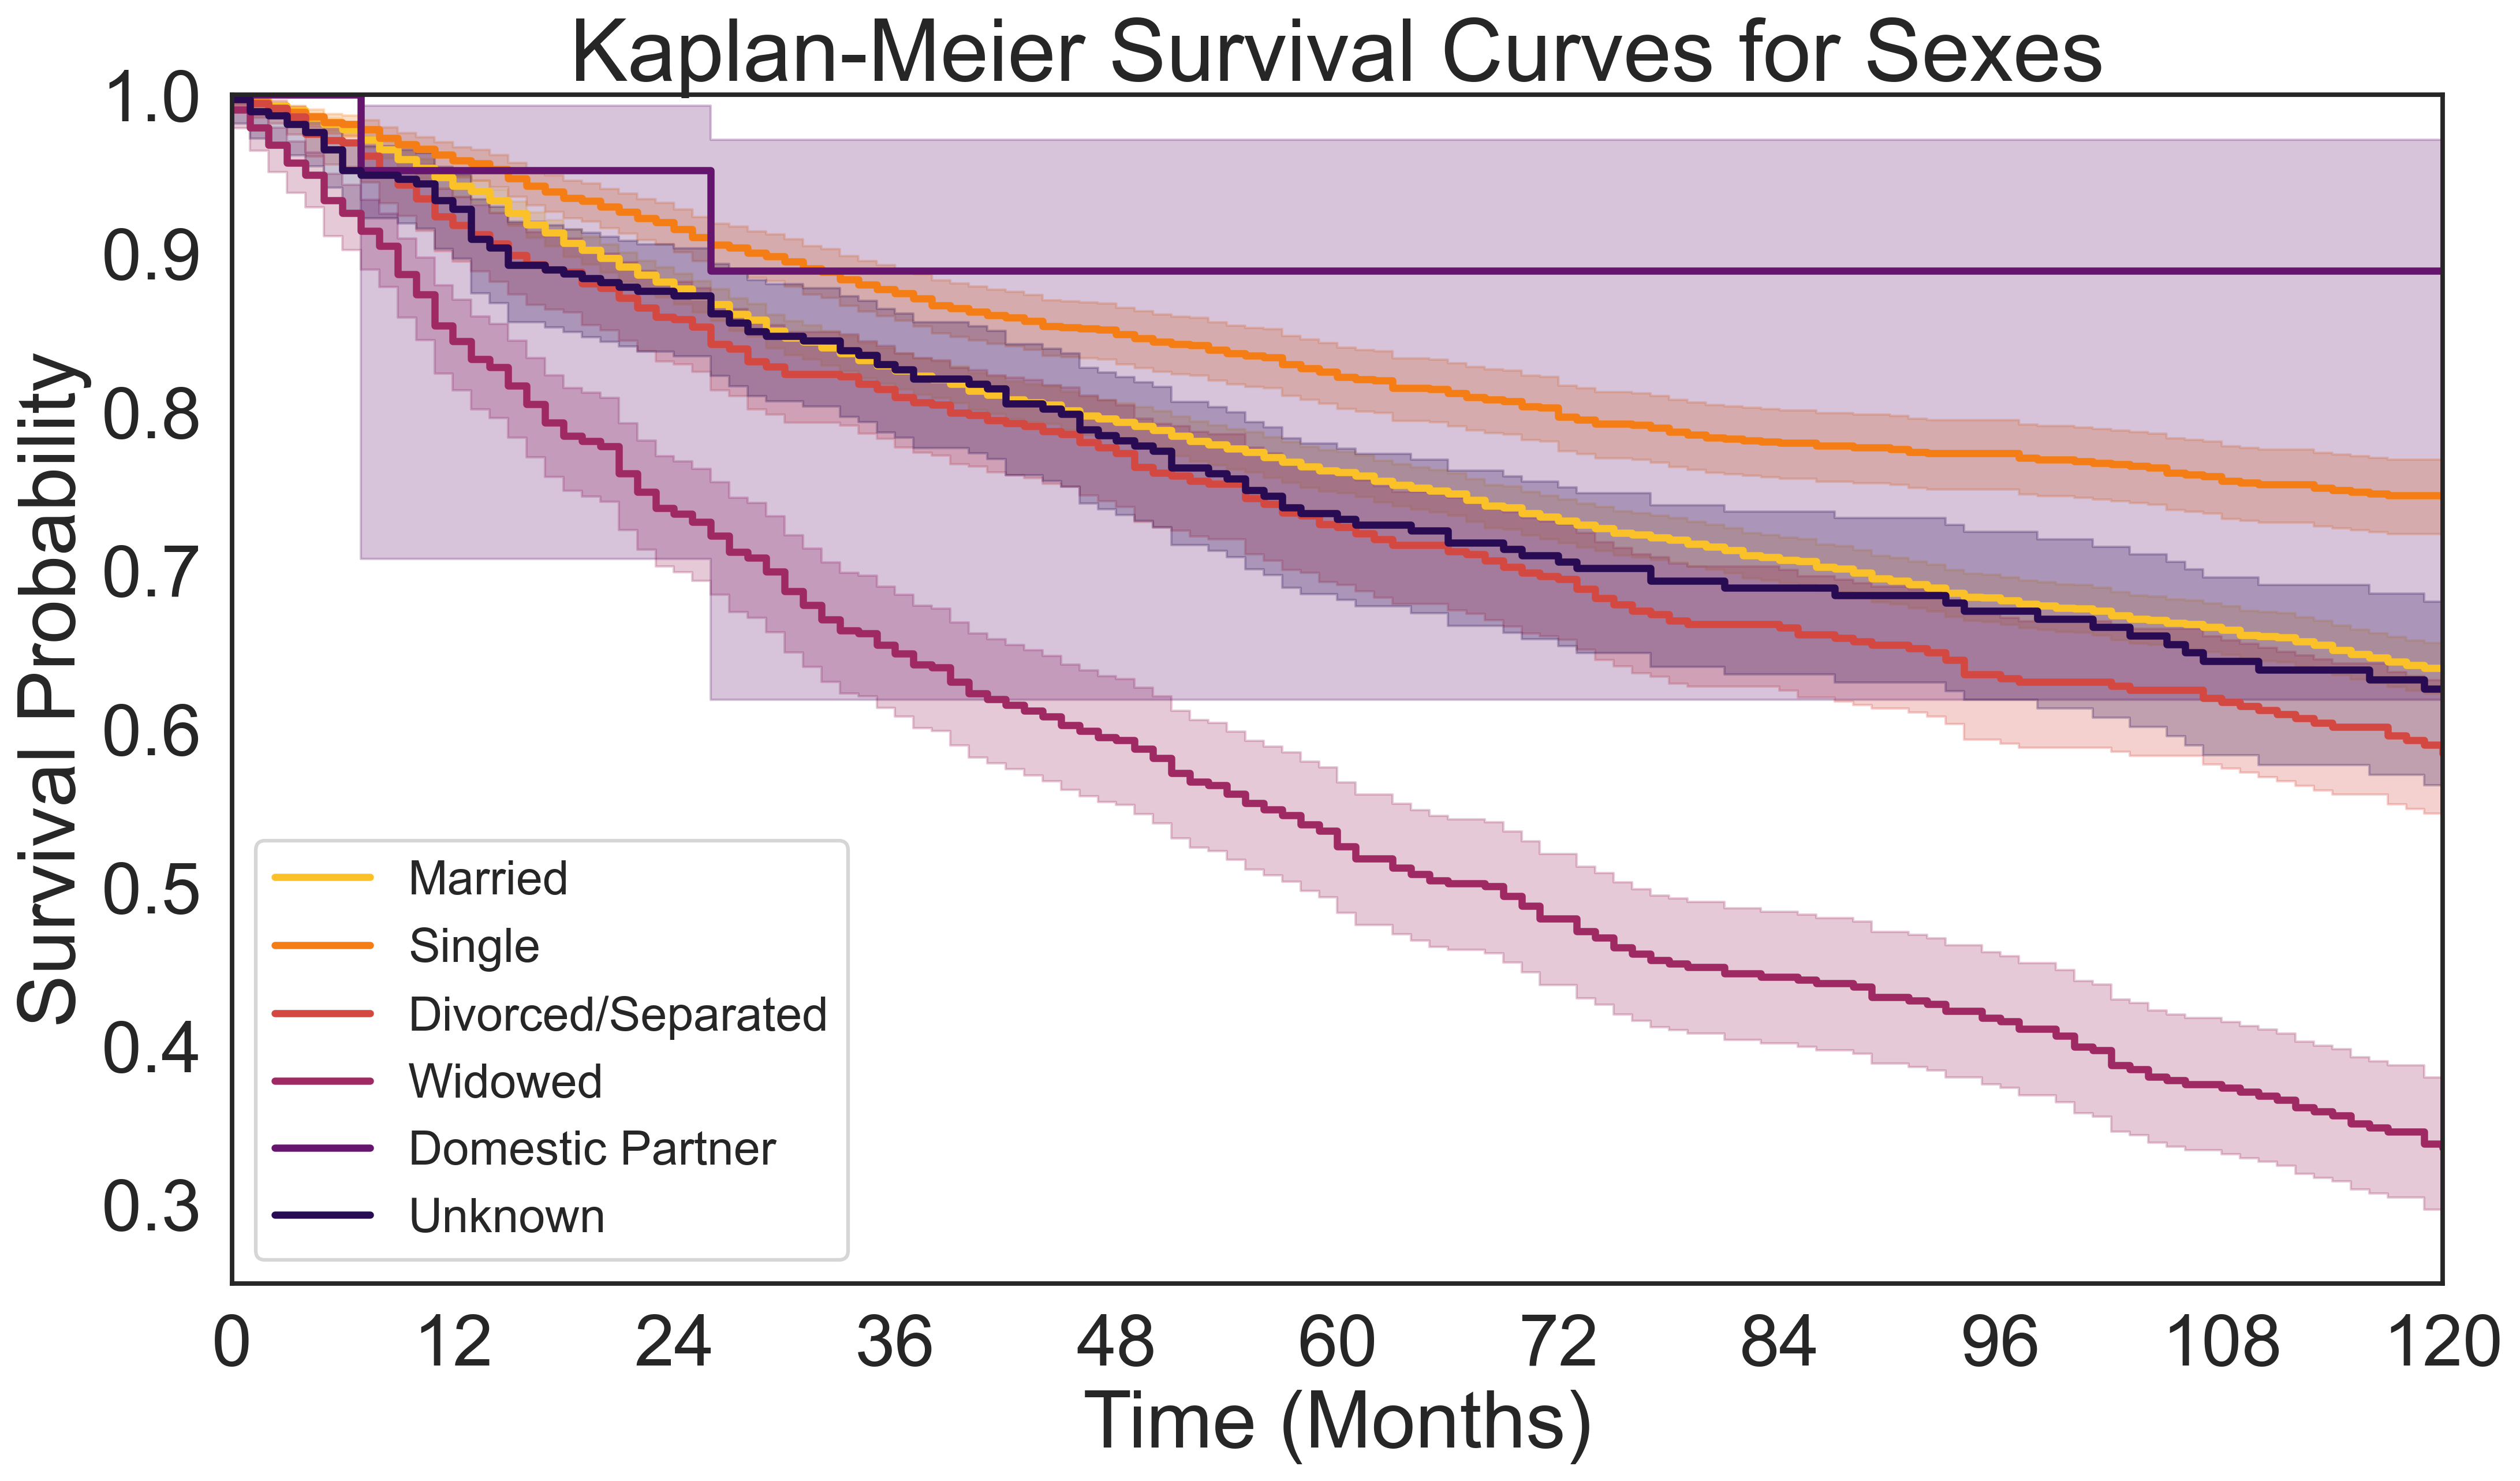

In [84]:

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset

marital_values = df[marital_colname].cat.categories

# Make new color dictionary
mSColorDict = {maritalStatus: color for maritalStatus, color in zip(marital_values, marital_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for ms in marital_values:
    # Filter the DataFrame for each cancer type
    df_ms = df[df[marital_colname] == ms]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_ms['Survival months'], event_observed=df_ms['event_occurred'], label=ms)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=mSColorDict[ms])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
plt.title('Kaplan-Meier Survival Curves for Sexes', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(.25, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = marital_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
# plt.savefig('km_survival10year.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Age?

# Cox Hazard Ratio

### Data Preparation including one-hot encoding and addressing collinearities

In [15]:
# Filter the dataset to include only relevant columns for the Cox model
cols_Tx = ['RX Summ--Scope Reg LN Sur (2003+)', 'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq', 'Reason no cancer-directed surgery', 'Radiation recode', 'Chemotherapy recode (yes, no/unk)', 'RX Summ--Systemic/Sur Seq (2007+)']
cox_df_updated = filtered_df_forKM[['Survival months', 'event_occurred', 'Age recode with single ages and 90+', 'Sex','Histology','Race recode (W, B, AI, API)','Grade Level','Median household income inflation adj to 2022'] + cols_Tx]
cox_df_updated = cox_df_updated[cox_df_updated['Survival months'] <= 120]

# Handle special cases in various columns
age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
cox_df_updated['Age recode with single ages and 90+'] = cox_df_updated['Age recode with single ages and 90+'].replace(age_replacement).astype(float)

cox_df_updated['Race recode (W, B, AI, API)'] = pd.Categorical(cox_df_updated['Race recode (W, B, AI, API)'],
                                                               categories=['White', 'Black', 'Asian or Pacific Islander', 'American Indian/Alaska Native', 'Unknown'],
                                                               ordered=True)

# Drop rows where required fields are missing (e.g., Survival months or event_occurred)
cox_df_updated = cox_df_updated.dropna(subset=['Survival months', 'event_occurred'])

### Simplify Treatment rows ###
# Define your map for LYMPH NODE REMOVAL
scopeSurgMap = {
    '4 or more regional lymph nodes removed': 'Lymph Nodes Removed',
    '1 to 3 regional lymph nodes removed': 'Lymph Nodes Removed',
    'Sentinel node biopsy and lym nd removed same/unstated time': 'Lymph Nodes Removed',
    'Sentinel node biopsy and lym nd removed different times': 'Lymph Nodes Removed'
}
# Apply the mapping and fill the rest with "Lymph nodes not removed/Unknown"
cox_df_updated['RX Summ--Scope Reg LN Sur recode'] = cox_df_updated['RX Summ--Scope Reg LN Sur (2003+)'].map(scopeSurgMap).fillna("Lymph Nodes Removed: No/Unknown")
cox_df_updated['RX Summ--Scope Reg LN Sur recode'] = pd.Categorical(cox_df_updated['RX Summ--Scope Reg LN Sur recode'],
                                                                    categories=['Lymph Nodes Removed: No/Unknown','Lymph Nodes Removed'],
                                                                    ordered=True)

# Define your map for RADIATION WITH/WITHOUT SURGERY
# cox_df_updated['RX Summ-Surg/Rad Seq recode'] = cox_df_updated['RX Summ--Surg/Rad Seq'].apply(
#     lambda x: 'No radiation' if x == 'No radiation and/or no surgery; unknown if surgery and/or radiation given' else 'Surgery and radiation'
# )
# cox_df_updated['RX Summ-Surg/Rad Seq recode'] = pd.Categorical(cox_df_updated['RX Summ-Surg/Rad Seq recode'],
#                                                                categories=['No radiation','Surgery and radiation'],
#                                                                ordered=True)

# Defined your map for 'Reason no cancer-directed surgery' Surgery performed? Yes/No/Unknown simplification
surgPerformedMap = {'Surgery performed':'Surgery: Yes',
                    'Not recommended':'Surgery: No',
                    'Not recommended, contraindicated due to other cond; autopsy only (1973-2002)':'Surgery: No',
                    'Recommended but not performed, unknown reason':'Surgery: No',
                    'Recommended but not performed, patient refused':'Surgery: No',
                    'Not performed, patient died prior to recommended surgery':'Surgery: No'}

# Apply the mapping; fill the rest with "Unknown if surgery performed"
cox_df_updated['Reason no cancer-directed surgery recode'] = cox_df_updated['Reason no cancer-directed surgery'].map(surgPerformedMap).fillna('Surgery: Unknown')
cox_df_updated['Reason no cancer-directed surgery recode'] = pd.Categorical(cox_df_updated['Reason no cancer-directed surgery recode'],
                                                                            categories=['Surgery: No','Surgery: Yes','Surgery: Unknown'],
                                                                            ordered=True)

# Define and apply radiation recode mapping 
radiationTypeMap = {'None/Unknown':'Radiotherapy: Unknown',
                    'Refused (1988+)': 'Radiotherapy: No',
                    'Recommended, unknown if administered': 'Radiotherapy: Unknown'}
cox_df_updated['Radiation recode recode'] = cox_df_updated['Radiation recode'].map(radiationTypeMap).fillna('Radiotherapy: Yes')

cox_df_updated['Radiation recode recode'] = pd.Categorical(cox_df_updated['Radiation recode recode'],
                                                           categories=['Radiotherapy: No','Radiotherapy: Yes','Radiotherapy: Unknown'],
                                                           ordered=True)

# Defined systemic therapy recode mapping
systemicMap = {'No systemic therapy and/or surgical procedures': 'No systemic therapy',
               'Blank(s)': 'Unknown'}

# 
cox_df_updated['RX Summ--Systemic/Sur Seq recode'] = cox_df_updated['RX Summ--Systemic/Sur Seq (2007+)'].map(systemicMap).fillna('')

cox_df_updated['RX Summ--Systemic/Sur Seq recode'] = pd.Categorical(cox_df_updated['RX Summ--Systemic/Sur Seq recode'],
                                                                    categories=['No systemic therapy','Systemic therapy and surgery'],
                                                                    ordered=True)
# Drop original + unnecessary columns from Cox PH df 
cox_df_updated.drop(cols_Tx,axis=1,inplace=True)

# Define a function to extract numerical values from median income
def extract_midpoint(income_str):
    # Check if the income string represents an open-ended range (e.g., "$120,000+")
    income_str = income_str.replace(',','')
    if '+' in income_str:
        # Extract the number before the '+' and return it as a float
        return float(re.sub(r'[^\d]', '', income_str))

    # Check if the income string represents a range (e.g., "$40,000 - $44,999")
    elif '-' in income_str:
        # Extract the two numbers and calculate the midpoint
        numbers = re.findall(r'\d+', income_str)
        lower_bound = float(numbers[0])
        upper_bound = float(numbers[1])
        midpoint = (lower_bound + upper_bound) / 2
        return midpoint

    # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
    elif '<' in income_str:
        # Extract the number and treat it as the threshold value
        return float(re.sub(r'[^\d]', '', income_str))

    # If the string does not match any of the patterns, return NaN
    return np.nan

# Apply the function to the income column
cox_df_updated['Income_numeric'] = cox_df_updated['Median household income inflation adj to 2022'].apply(extract_midpoint)

# Ensure the 'Income_numeric' column is converted to a numeric type
cox_df_updated['Income_numeric'] = pd.to_numeric(cox_df_updated['Income_numeric'], errors='coerce')

# Set the median threshold based on 2022 numbers
median_income_threshold = 77540

# Create a new column based on the comparison with the median
cox_df_updated['Income_above_below_median'] = np.where(
    cox_df_updated['Income_numeric'] > median_income_threshold,
    'Above median',
    'Below median'
)

# Get rid of old median income columns
cox_df_updated.drop(['Median household income inflation adj to 2022','Income_numeric'],axis=1,inplace=True)


# Apply One Hot Encoding for Cox PH Analysis
cox_df_updated_encoded = pd.get_dummies(cox_df_updated, columns=[
    'Sex', 'Race recode (W, B, AI, API)', 'Histology', 'Grade Level', 'RX Summ--Scope Reg LN Sur recode',
    'Reason no cancer-directed surgery recode',
    'Radiation recode recode', 'RX Summ--Systemic/Sur Seq recode',
    'Income_above_below_median'], drop_first=True)

# Drop any remaining rows with missing values
cox_df_updated_encoded = cox_df_updated_encoded.dropna()

# Check the correlation between variables (only numerical columns)
correlation_matrix = cox_df_updated_encoded.corr()
# Drop any remaining rows with missing values
cox_df_updated_encoded = cox_df_updated_encoded.dropna()

cox_df_updated_encoded.drop('Age recode with single ages and 90+', axis=1, inplace=True)

# Display high correlations (e.g., above 0.8)
high_corr = correlation_matrix[(correlation_matrix > 0.75) & (correlation_matrix < 1)].stack()
if high_corr.empty:
    print('Multicollinearities not likely')
else:
    print(high_corr)



Multicollinearities not likely


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_24953/949560082.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cox_df_updated['Age recode with single ages and 90+'] = cox_df_updated['Age recode with single ages and 90+'].replace(age_replacement).astype(float)


In [22]:
# Check for sparse variables (columns with many zeros)
sparsity_check = (cox_df_updated_encoded == 0).sum() / len(cox_df_updated_encoded)
print(sparsity_check[sparsity_check > 0.9])

# Drop sparse data columns
cox_df_updated_encoded.drop(list(sparsity_check[sparsity_check > 0.9].index), axis=1, inplace=True)

print(cox_df_updated_encoded.columns)

# cox_df_updated_encoded.drop(['Reason no cancer-directed surgery recode_Surgery: Unknown','RX Summ--Systemic/Sur Seq recode_Systemic therapy and surgery'],axis=1,inplace=True)

Series([], dtype: float64)
Index(['Survival months', 'event_occurred', 'Sex_Male',
       'Race recode (W, B, AI, API)_Black',
       'Race recode (W, B, AI, API)_Asian or Pacific Islander',
       'Histology_Adenoid Cystic Carcinoma',
       'Histology_Mucoepidermoid Carcinoma', 'Grade Level_Intermediate',
       'Grade Level_High', 'Grade Level_Unknown',
       'RX Summ--Scope Reg LN Sur recode_Lymph Nodes Removed',
       'Reason no cancer-directed surgery recode_Surgery: Yes',
       'Radiation recode recode_Radiotherapy: Yes',
       'Radiation recode recode_Radiotherapy: Unknown',
       'Income_above_below_median_Below median'],
      dtype='object')


###  Model Fitting 1

coef  exp(coef)  \
covariate                                                                 
Sex_Male                                            0.333808   1.396275   
Race recode (W, B, AI, API)_Black                   0.001111   1.001112   
Race recode (W, B, AI, API)_Asian or Pacific Is... -0.336445   0.714305   
Histology_Adenoid Cystic Carcinoma                  0.004422   1.004432   
Histology_Mucoepidermoid Carcinoma                 -0.194590   0.823172   
Grade Level_Intermediate                            0.241429   1.273067   
Grade Level_High                                    1.423255   4.150608   
Grade Level_Unknown                                 0.489894   1.632144   
RX Summ--Scope Reg LN Sur recode_Lymph Nodes Re... -0.301499   0.739708   
Reason no cancer-directed surgery recode_Surger... -1.087363   0.337104   
Radiation recode recode_Radiotherapy: Yes          -0.143613   0.866223   
Radiation recode recode_Radiotherapy: Unknown      -0.307074   0.735596   
Income_above_below_median_Below median              0.072199   1.074869   

                                                    se(coef)  coef lower 95%  \
covariate                                                                      
Sex_Male                                            0.034044        0.267083   
Race recode (W, B, AI, API)_Black                   0.054666       -0.106032   
Race recode (W, B, AI, API)_Asian or Pacific Is...  0.064744       -0.463340   
Histology_Adenoid Cystic Carcinoma                  0.044374       -0.082549   
Histology_Mucoepidermoid Carcinoma                  0.037442       -0.267976   
Grade Level_Intermediate                            0.066050        0.111973   
Grade Level_High                                    0.061370        1.302972   
Grade Level_Unknown                                 0.060456        0.371403   
RX Summ--Scope Reg LN Sur recode_Lymph Nodes Re...  0.035996       -0.372051   
Reason no cancer-directed surgery recode_Surger...  0.045930       -1.177385   
Radiation recode recode_Radiotherapy: Yes           0.098960       -0.337570   
Radiation recode recode_Radiotherapy: Unknown       0.099446       -0.501984   
Income_above_below_median_Below median              0.033329        0.006875   

                                                    coef upper 95%  \
covariate                                                            
Sex_Male                                                  0.400533   
Race recode (W, B, AI, API)_Black                         0.108255   
Race recode (W, B, AI, API)_Asian or Pacific Is...       -0.209550   
Histology_Adenoid Cystic Carcinoma                        0.091394   
Histology_Mucoepidermoid Carcinoma                       -0.121205   
Grade Level_Intermediate                                  0.370886   
Grade Level_High                                          1.543538   
Grade Level_Unknown                                       0.608386   
RX Summ--Scope Reg LN Sur recode_Lymph Nodes Re...       -0.230948   
Reason no cancer-directed surgery recode_Surger...       -0.997341   
Radiation recode recode_Radiotherapy: Yes                 0.050344   
Radiation recode recode_Radiotherapy: Unknown            -0.112163   
Income_above_below_median_Below median                    0.137522   

                                                    exp(coef) lower 95%  \
covariate                                                                 
Sex_Male                                                       1.306149   
Race recode (W, B, AI, API)_Black                              0.899396   
Race recode (W, B, AI, API)_Asian or Pacific Is...             0.629178   
Histology_Adenoid Cystic Carcinoma                             0.920766   
Histology_Mucoepidermoid Carcinoma                             0.764926   
Grade Level_Intermediate                                       1.118482   
Grade Level_High                                               3.680217   
Gra

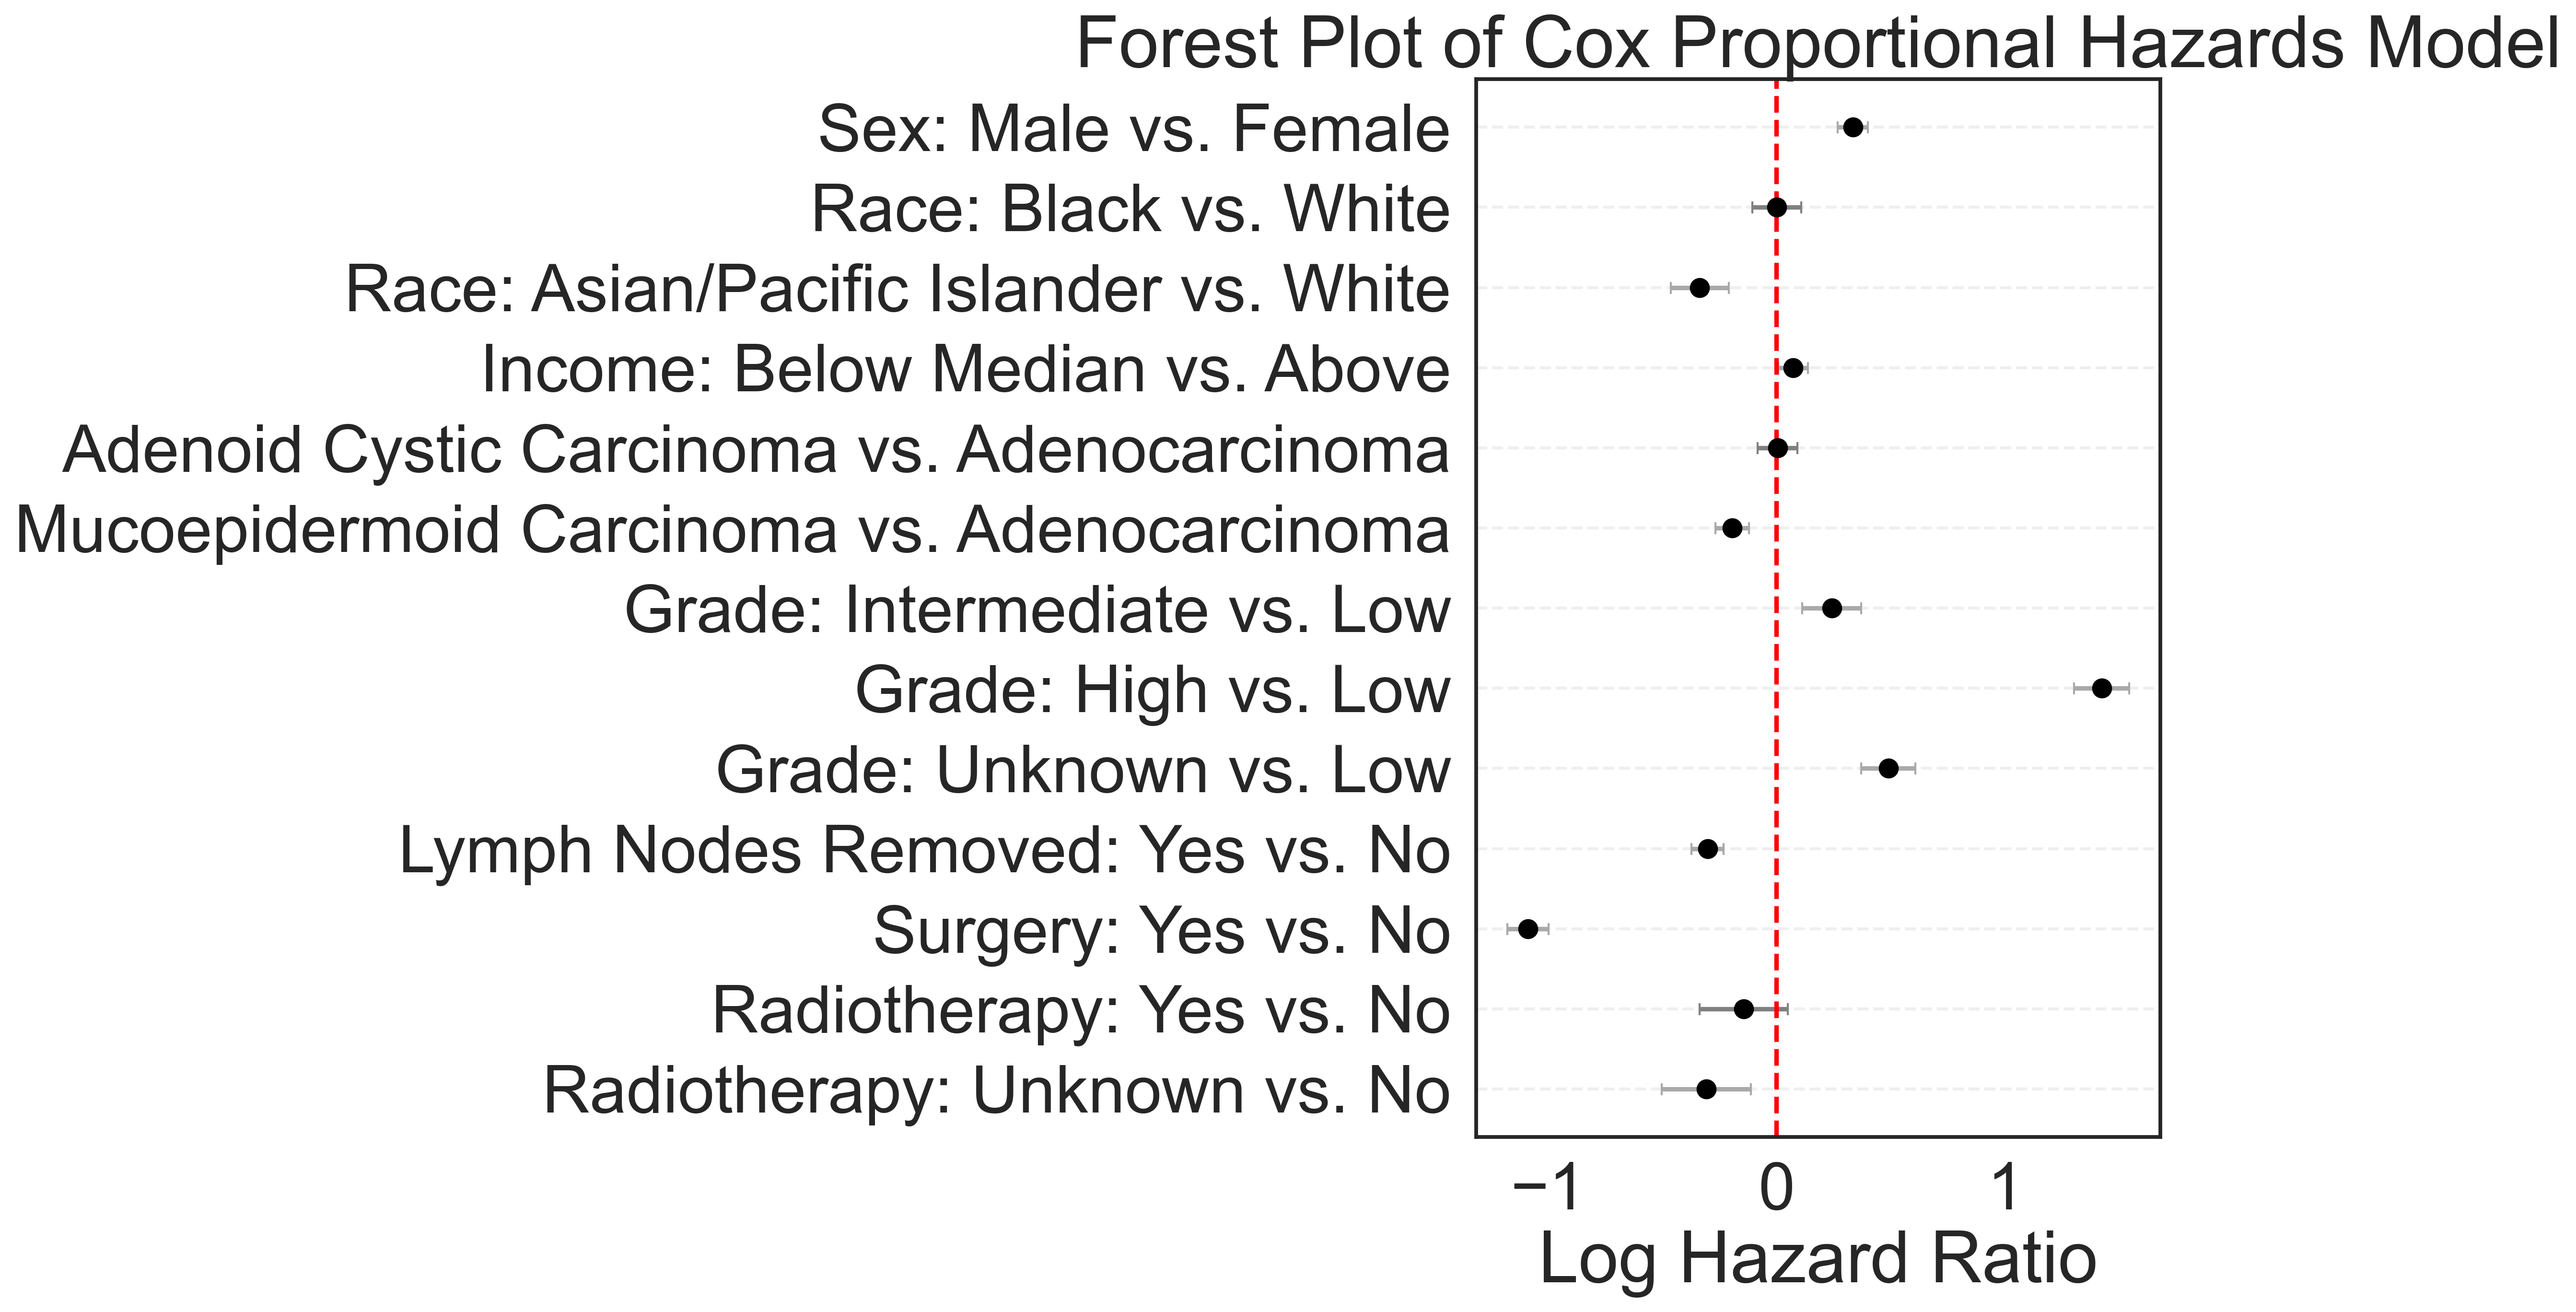

In [17]:
# Fit Cox model
cox_model = CoxPHFitter(penalizer=0.01)
cox_model.fit(cox_df_updated_encoded, duration_col='Survival months', event_col='event_occurred')

# Export summary
cox_summary = cox_model.summary
output_file_path = 'cox_model_summary.xlsx'
cox_summary.to_excel(output_file_path)

# Extract coefficients, confidence intervals, and p-values
coef = cox_model.summary['coef']
lower_ci = cox_model.summary['coef lower 95%']
upper_ci = cox_model.summary['coef upper 95%']
p_values = cox_model.summary['p']
variables = coef.index

display(cox_summary)
cox_summary
# Labels
new_labels = {
    'Sex_Male': 'Sex: Male vs. Female',
    'Race recode (W, B, AI, API)_Black': 'Race: Black vs. White',
    'Race recode (W, B, AI, API)_Asian or Pacific Islander': 'Race: Asian/Pacific Islander vs. White',
    'Income_above_below_median_Below median': 'Income: Below Median vs. Above',
    'Histology_Adenoid Cystic Carcinoma': 'Adenoid Cystic Carcinoma vs. Adenocarcinoma',
    'Histology_Mucoepidermoid Carcinoma': 'Mucoepidermoid Carcinoma vs. Adenocarcinoma',
    # 'Grade Label_Grade II': 'Grade II vs. Grade I',
    # 'Grade Label_Grade III': 'Grade III vs. Grade I',
    # 'Grade Label_Unknown':'Unknown Grade vs. Grade I',
    'Grade Level_Unknown': 'Grade: Unknown vs. Low',
    'Grade Level_Intermediate': 'Grade: Intermediate vs. Low',
    'Grade Level_High': 'Grade: High vs. Low',
    'RX Summ--Scope Reg LN Sur recode_Lymph Nodes Removed': 'Lymph Nodes Removed: Yes vs. No',
    'Reason no cancer-directed surgery recode_Surgery: Yes': 'Surgery: Yes vs. No',
    'Radiation recode recode_Radiotherapy: Yes': 'Radiotherapy: Yes vs. No',
    'Radiation recode recode_Radiotherapy: Unknown': 'Radiotherapy: Unknown vs. No',
    
}

# Define the order and reverse it
order = [
    'Sex_Male',
    'Race recode (W, B, AI, API)_Black',
    'Race recode (W, B, AI, API)_Asian or Pacific Islander',
    'Income_above_below_median_Below median',
    'Histology_Adenoid Cystic Carcinoma',
    'Histology_Mucoepidermoid Carcinoma',
    'Grade Level_Intermediate',
    'Grade Level_High',
    'Grade Level_Unknown',
    'RX Summ--Scope Reg LN Sur recode_Lymph Nodes Removed',
    'Reason no cancer-directed surgery recode_Surgery: Yes',
    'Radiation recode recode_Radiotherapy: Yes',
    'Radiation recode recode_Radiotherapy: Unknown',
    
    ]
order = order[::-1]

# Reorder coefficients and confidence intervals and convert to hazard ratios
# coefficients_ordered = np.exp(np.array([coef[label] for label in order]))
# lower_ci_ordered = np.exp(np.array([lower_ci[label] for label in order]))
# upper_ci_ordered = np.exp(np.array([upper_ci[label] for label in order]))
# xlineval = 1
# xlabelval = 'Hazard Ratio'

# Reorder coefficients and confidence intervals and don't convert to hazard ratios
coefficients_ordered = (np.array([coef[label] for label in order]))
lower_ci_ordered = (np.array([lower_ci[label] for label in order]))
upper_ci_ordered = (np.array([upper_ci[label] for label in order]))
xlineval = 0
xlabelval = 'Log Hazard Ratio'

# Highlight significant p-values
significant = p_values < 0.05

# Error bars
errors_ordered = [coefficients_ordered - lower_ci_ordered, upper_ci_ordered - coefficients_ordered]

# Plot setup
fig, ax = plt.subplots(figsize=(16, 10))

# Plot with significant points highlighted
for i, label in enumerate(order):
    if significant[label]:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='darkgrey', capsize=3)  # Significant in red
    else:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='grey', capsize=3)

# Add a vertical line for hazard ratio = 1
plt.axvline(x=xlineval, color='red', linestyle='--')

# Update the y-tick labels to the new labels, in the specified order
ax.set_yticks(range(len(order)))
ax.set_yticklabels([new_labels[label] for label in order])

# Set X-axis
# plt.xlim(-.25,2.25)

# Customize the plot
plt.xlabel(xlabelval)
plt.title('Forest Plot of Cox Proportional Hazards Model')

# Add gridlines for y-axis (horizontal lines)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('cox_forest_plot.png', dpi=300, bbox_inches='tight')  # Save the plot as a PNG file

# Show the plot
plt.show()

## Data preparation and mean-encoding for demographic determinants

/opt/anaconda3/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column sex have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'sex'].var())
>>> print(df.loc[~events, 'sex'].var())

A very low variance means that the column sex completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.535. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the datas

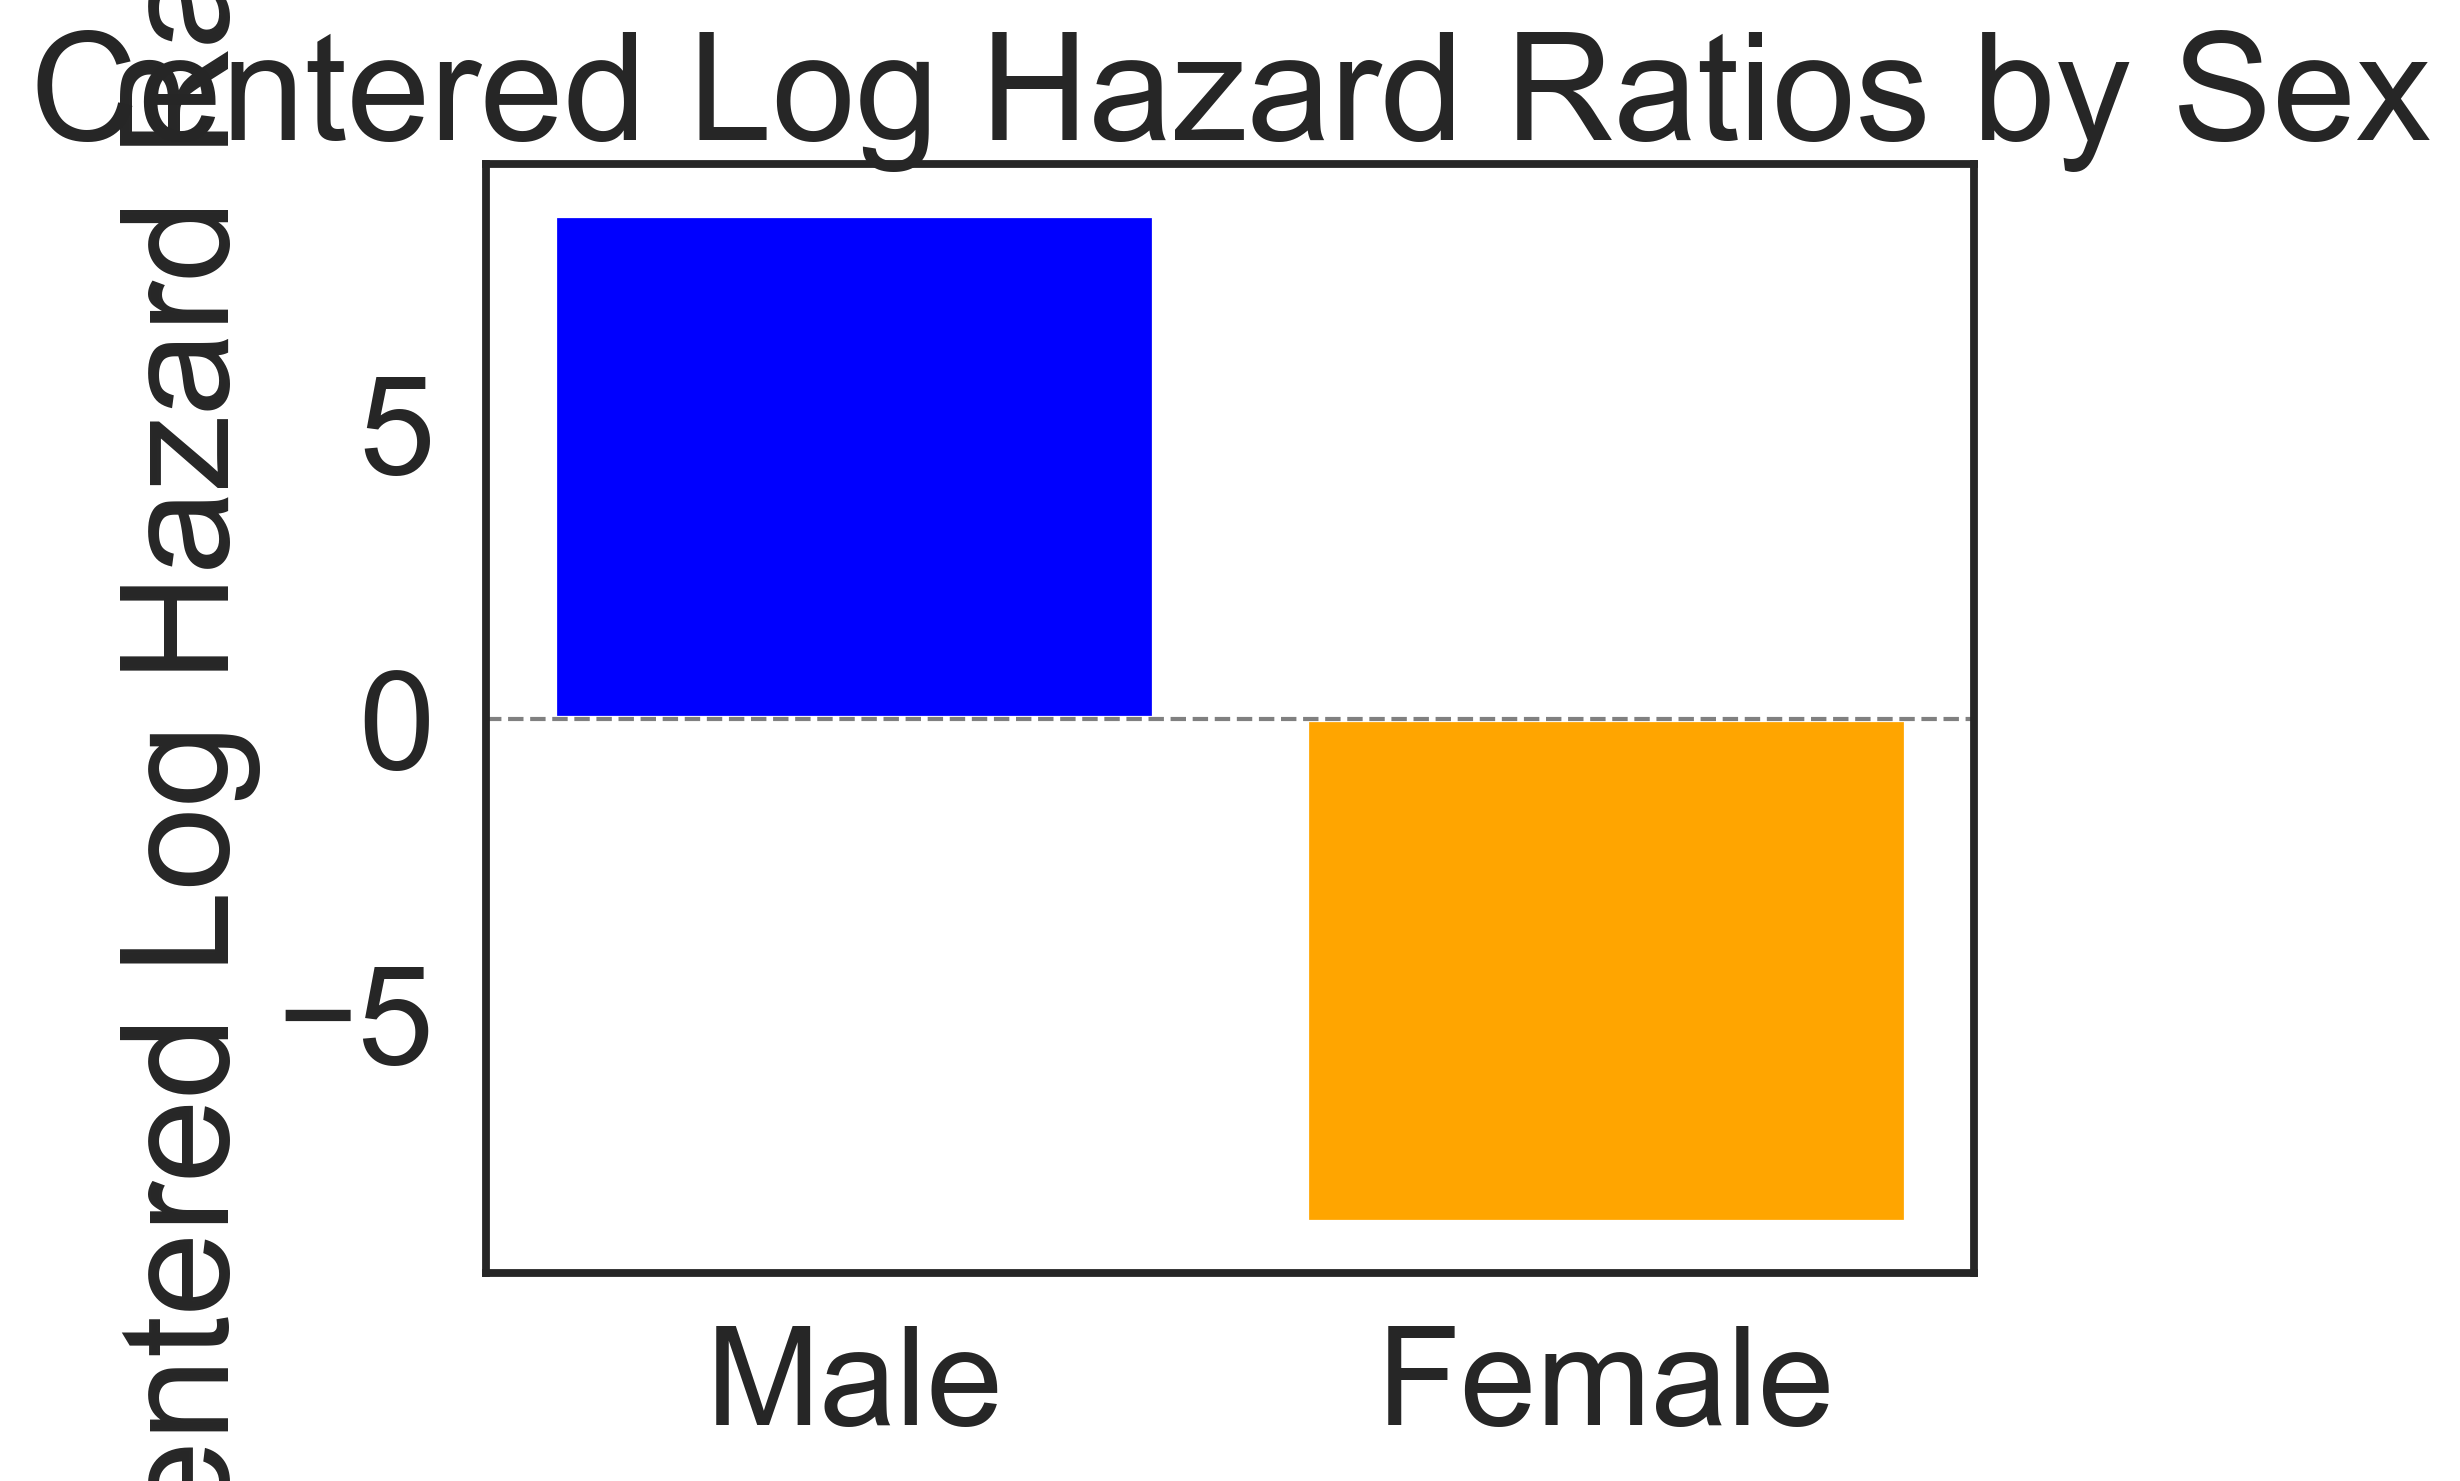

In [19]:
# Filter the dataset to include only relevant columns for the Cox model
demographic_determinants = ['Age recode with single ages and 90+', 'Sex','Histology','Race recode (W, B, AI, API)','Grade Level','Income_quartile' ]
df_cox_dem = df[demographic_determinants + ['Survival months','event_occurred']] # df is used above during KM survival curves analysis
df_cox_dem = df_cox_dem[df_cox_dem['Survival months'] <= 120]

# Handle special cases in age column then rename for ease.
age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
df_cox_dem['Age recode with single ages and 90+'] = df_cox_dem['Age recode with single ages and 90+'].replace(age_replacement).astype(float)
df_cox_dem = df_cox_dem.rename(columns={'Race recode (W, B, AI, API)':'Race', 'Age recode with single ages and 90+':'Age'})

# Identify categorical columns
categorical_columns = df_cox_dem.select_dtypes(include='category').columns.tolist()
print(categorical_columns)

df_encoded = df_cox_dem.copy()
# Perform mean encoding in each categorical column:
for col in categorical_columns:
    # Calculate mean Survival months for each category
    category_means = df_encoded.groupby(col)['Survival months'].mean()
    
    # Map the deviation back to the column
    df_encoded[col] = df_encoded[col] - category_means

# Fit Cox PH model
cox_model = CoxPHFitter()
cox_model.fit(df_encoded, duration_col='Survival months', event_col='event_occurred')

# View results
cox_model.print_summary()

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_24953/173469218.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_cox_dem['Age recode with single ages and 90+'] = df_cox_dem['Age recode with single ages and 90+'].replace(age_replacement).astype(float)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_24953/173469218.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = df_encoded.groupby(col)['Survival months'].mean()


['Sex', 'Histology', 'Race', 'Grade Level', 'Income_quartile']


TypeError: Object with dtype category cannot perform the numpy op subtract

## Model Fitting 2

In [ ]:
# # Initialize the CoxPH model
# cox_model = CoxPHFitter()
# 
# # Fit the model
# cox_model.fit(cox_design_matrix, duration_col='Survival months', event_col='event_occurred')
# 
# # View the summary
# cox_model.print_summary()  # Displays coefficients, p-values, confidence intervals, etc.

# Being Male as a Risk Factor? Sex and Grade Level

In [ ]:

# Group by 'Sex' and 'Grade Label' and sort based on the defined order
result = (
    cox_df_updated[['Sex', 'Histology', 'Grade Level']]
    .groupby('Sex', observed=False)['Grade Level']
    .value_counts()
    .sort_index(level=['Sex', 'Grade Level'])
)
print(result)
# Convert the result to a DataFrame and reset index
result_df = result.reset_index()
display(result_df)
# Plot the result using seaborn
plt.figure(figsize=(20, 15))
sns.barplot(
    data=result_df,
    x='Grade Level',
    y='count',
    hue='Sex',
    palette='RdBu'
)

# Set labels and title
plt.xlabel('Grade')
plt.ylabel('Number of Cases')
# plt.title('Counts of Grade Level by Sex')

# Save & Display the plot
plt.tight_layout()
plt.savefig('FvM_GradeCounts.png',dpi=300,bbox_inches='tight')
plt.show()


# Race and Grade Level

In [ ]:
# Group by 'Race' and 'Grade Label' and sort based on the defined order
result = (
    cox_df_updated[['Race recode (W, B, AI, API)', 'Grade Level']]
    .groupby('Race recode (W, B, AI, API)', observed=False)['Grade Level']
    .value_counts()
    .sort_index(level=['Race recode (W, B, AI, API)', 'Grade Level'])
)
print(result)
# Convert the result to a DataFrame and reset index
result_df = result.reset_index()
display(result_df)
# Plot the result using seaborn
plt.figure(figsize=(20, 15))
sns.barplot(
    data=result_df,
    x='Grade Level',
    y='count',
    hue='Race recode (W, B, AI, API)',
    palette='rocket_r'
)

# Set labels and title
plt.xlabel('Grade')
plt.ylabel('Number of Cases')
# plt.title('Counts of Grade Level by Sex')

# Save & Display the plot
plt.tight_layout()
plt.savefig('Race_GradeCounts.png',dpi=300,bbox_inches='tight')
plt.show()


# Race and Income

In [ ]:
result_total = (
    cox_df_updated[['Race recode (W, B, AI, API)', 'Income_above_below_median', 'event_occurred']]
    .groupby('Race recode (W, B, AI, API)', observed=False)[['Income_above_below_median']]
    .value_counts()
    .sort_index(level=['Race recode (W, B, AI, API)', 'Income_above_below_median'])
)

result_survival = (
    cox_df_updated[['Race recode (W, B, AI, API)', 'Income_above_below_median', 'event_occurred']]
    .groupby('Race recode (W, B, AI, API)', observed=False)[['Income_above_below_median','event_occurred']]
    .value_counts()
    .sort_index(level=['Race recode (W, B, AI, API)', 'Income_above_below_median'])
)
# Convert the result to a DataFrame and reset index
result_df_total = result_total.reset_index()
# display(result_df_total)

result_df_survival = result_survival.reset_index()
# display(result_df_survival)

# Plot the result using seaborn
plt.figure(figsize=(20, 15))

# Generate the 'rocket_r' palette
rocket_palette = sns.color_palette("rocket_r", n_colors=10)
# Generate alternative slate of palettes
darkened_palette = sns.color_palette(rocket_palette[0:10:2], desat=.2)  # desat < 1 brightens the colors

# Create a count plot to visualize the counts with stacking by event_occurred and race differentiation
bp_total = sns.barplot(
    data=result_df_total,
    x='Income_above_below_median',  # X-axis is income above/below median
    y='count',  # Y-axis is the count of individuals
    hue='Race recode (W, B, AI, API)',  # Use race as the hue to differentiate the bars
    palette=rocket_palette[0:10:2],
    edgecolor='black',
    linewidth=2,
)

# Overlay a second bar plot for event_occurred (alive vs not alive) for stacked effect
bp_dead = sns.barplot(
    data=result_df_survival[result_df_survival['event_occurred']==1],
    x='Income_above_below_median',
    y='count',
    hue='Race recode (W, B, AI, API)',  # Use event_occurred to fill the bars for alive vs not alive
    palette=darkened_palette,
    edgecolor='black',
    linewidth=2,
    legend=False
)

plt.xlabel('Income')
plt.ylabel('Number of Cases')

# Adjust the legend fontsize
xlabel_fontsize = bp_total.xaxis.label.get_size()
plt.legend(fontsize=xlabel_fontsize * .7)  # Change legend fontsize and title fontsize

# Save & Display the plot
plt.tight_layout()
plt.savefig('Race_IncomeAboveBelowMedian.png',dpi=300,bbox_inches='tight')
plt.show()


# Logistic Regression
### Can we predict which patients are likely to die?

In [ ]:
# target variable
y = cox_df_updated_encoded['event_occurred']  # Use 'event_occurred' as the binary outcome variable

# Drop the target column from the feature set
X = cox_df_updated_encoded.drop(['event_occurred'], axis=1)

# Split the data into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=69)

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Predict on the test data
y_pred_log = log_reg.predict(X_test)

# Evaluate the Logistic Regression model
print("Logistic Regression Classifier Evaluation:")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

# ROC-AUC Score
log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score for Logistic Regression: {log_reg_roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {log_reg_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# Random Forest Classifier

In [ ]:
# rf_clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)

# 
# # Fit the model on the training data
# rf_clf.fit(X_train, y_train)
# 
# # Predict on the test data
# y_pred_rf = rf_clf.predict(X_test)
# 
# # Evaluate the Random Forest Classifier
# print("Random Forest Classifier Evaluation:")
# print(classification_report(y_test, y_pred_rf))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))

# # ROC-AUC Score for Random Forest
# rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
# print(f"ROC-AUC Score for Random Forest: {rf_roc_auc}")
# 
# # Plot ROC curve for Random Forest
# fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
# plt.figure(figsize=(10, 6))
# plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Random Forest')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier()

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 300],  # Number of trees
    'max_depth': [None, 5,6,7,8,9,10],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used
}

# Set up Randomized Search (search over 20 different combinations)
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring='roc_auc', verbose=2, random_state=69)

# Fit the Randomized Search model
random_search_rf.fit(X_train, y_train)

# Best parameters found by Randomized Search
print("Best parameters for Random Forest:", random_search_rf.best_params_)

# Make predictions using the best model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Evaluation after Hyperparameter Tuning:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))



# Calculate the ROC-AUC score using the best_rf_model (the fitted model from RandomizedSearchCV)
rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score for Random Forest: {rf_roc_auc}")

# Plot the ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()